In [1]:
# # Hide the code by default from the web page:
# # (from: http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer#28073228)
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the code."></form>
''')

# Benchmark resutlt

In [2]:
#!/usr/bin/env python
# coding: utf-8

import contracts
contracts.disable_all()

import geometry as geo
import math 
import numpy as np
from os import path, listdir
from scipy import stats
import yaml
import datetime
import pprint
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from math import ceil

import duckietown_world as dw
from duckietown_world.svg_drawing.ipython_utils import ipython_draw_svg, ipython_draw_html
from duckietown_world.world_duckietown.tile import get_lane_poses
from duckietown_world import draw_static


# import geometry_msgs
# import geometry_msgs.msg
# import geometry_msgs.msg._TransformStamped
# import geometry_msgs.msg._TransformStamped as TransformStamped

from os import path, listdir
import json
import yaml
# from scipy import interpolate

experiment_dir = ''

logs_path = path.join(experiment_dir, '../data/BenchmarkXY')

INFO:dt-world:duckietown-world 5.1.2
INFO:zuper-typing:zuper-typing 5.3.0
INFO:zuper-commons:zuper-commons 5.0.11


Below are some functions used

In [83]:
def relative_pose(q0, q1):
    "Computes the relative pose between two points in SE2"
    return geo.SE2.multiply(geo.SE2.inverse(q0), q1)

class AFakeBar(dw.PlacedObject):
    "Ellipse object with a large ration between the radii"

    def __init__(self, len=0, fill_opacity=0.5, color='pink', *args, **kwargs):
        self.len = len
        self.fill_opacity = fill_opacity
        self.color = color
        dw.PlacedObject.__init__(self, *args, **kwargs)

    def draw_svg(self, drawing, g):
        # drawing is done using the library svgwrite
        c = drawing.ellipse(center=(0, 0), r=(0.03,self.len), fill=self.color, fill_opacity=self.fill_opacity)
        g.add(c)
        # draws x,y axes
        dw.draw_axes(drawing, g)
        
def find_nearest_2d(mid_line, point, theta):
    """Function to find the nearest point on the midle line to a specific point in 2d"""
    """It then calculates the relative x and y offset of the point to the nearest point on the center line"""
    """ as well as the relative angle of the April Tag on your Duckiebot compared to the cener line"""
#     print(value)
    min_dist = 100000
    rel_offset_cr_min = 10000
#     print(type(mid_line))
    start = True
    indx = 0
    for i in range(1, len(mid_line)):
        xs_c = mid_line[i].p[0]
        ys_c = mid_line[i].p[1]
        xs_p = mid_line[i-1].p[0]
        ys_p = mid_line[i-1].p[1]
        p1 = np.array([xs_p,ys_p])
        p2 = np.array([xs_c,ys_c])
        p3 = np.array([point[0],point[1]])
        rel_offset_cr = np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
        if rel_offset_cr < rel_offset_cr_min:
            rel_offset_cr_min = rel_offset_cr
            indx = i
        dist = (point[0]-xs_c)**2 + (point[1]-ys_c)**2
        if dist < min_dist:
            min_dist = dist
            
        
            
    rel_x = point[0] - mid_line[indx].p[0] 
    rel_y = point[1] - mid_line[indx].p[1] 
    rel_angle = mid_line[indx].theta
    theta_rel = np.arctan2(np.mean(np.sin(theta-rel_angle)),np.mean(np.cos(theta-rel_angle)))
    
#     indx = (mid_line.index(idx))    
    return indx, rel_x, rel_y, theta_rel, rel_offset_cr_min

class Circle(dw.PlacedObject):
    "Circle object."

    def __init__(self, radius, color='pink', *args, **kwargs):
        self.radius = radius
        self.color = color
        dw.PlacedObject.__init__(self, *args, **kwargs)

    def draw_svg(self, drawing, g):
        # drawing is done using the library svgwrite
        c = drawing.circle(center=(0, 0), r=self.radius, fill=self.color)
        g.add(c)
        # draws x,y axes
        dw.draw_axes(drawing, g)

    def extent_points(self):
        # set of points describing the boundary
        L = self.radius
        return [(-L, -L), (+L, +L)]
    
    
def interpolate_custom(q0, q1, alpha):
    "Interpolates between two points in SE2, given a coefficient alpha."
    q1_from_q0 = relative_pose(q0, q1)
    vel = geo.SE2.algebra_from_group(q1_from_q0)
    rel = geo.SE2.group_from_algebra(vel * alpha)
    q = geo.SE2.multiply(q0, rel)
    return q

def get_global_center_line(map, used_lane_segs, global_segs_SE2, pts_per_segment, length):
    "Builds a center line for all the used lanes in the global coordinate frame."
    center_line = []
    center_line_global = []
    center_line_global_tfs = []
    
    # The number of points genereated for the center line depends on the tile 
    # mid is the number of points for a straight tile
    # long is the number of points for a left curve tile
    # short is the number of points for a right curve tile
    for i, lane_segment in enumerate(used_lane_segs):
        if lane_segment[2] == 'straight':
            n_inter = int(pts_per_segment['mid'])
        elif lane_segment[-1] == 'lane2':
            n_inter = int(pts_per_segment['long'])
        elif lane_segment[-1] == 'lane1':
            n_inter = int(pts_per_segment['short'])
        lane = map[lane_segment]

        # The end point is part of next tile
        steps = np.linspace(0, len(lane.control_points) - 1, num=n_inter, endpoint=False)

        for beta in steps:
            center_point_local_SE2 = lane.center_point(beta)
            center_line.append(center_point_local_SE2)

            # get SE2 of the point in global coords
            center_point_global_SE2 = geo.SE2.multiply(global_segs_SE2[lane_segment],
                                                       center_point_local_SE2)

            center_line_global.append(center_point_global_SE2)
            center_line_global_tfs.append(dw.SE2Transform.from_SE2(center_point_global_SE2))

    
    
    return center_line_global, center_line_global_tfs

def get_used_lanes_mine(trajectories):
    """Returns a list with all used lanes and a dictionary containing the transform to each lane segment."""
    """It also calculates the number of completed laps, the time needed per tile and it counts the number"""
    """of tiles covered (total as well as specific for different types)"""
    """Moreover it checks if the Duckiebot had a crash or drives too slow -> if the center of the April Tag"""
    """of the  Duckiebot takes more than 30 seconds to get across one tile the Benchmark is stoped there"""
    """The time when this happened is saved and the trajectories are shorten to that time"""
    
    # If in future for another Benchmark there are other tiles part of the loop just add a dictionary for them as well
    used_lane_segs = set()
    used_lane_segs_list = []
    lane_segs_tfs = dict()
    last_lane_seg = dict()
    prev_lane_seg = ()
    current_lane_seg = ()
    start_tile = ()
    
    total_nb_of_tiles = 0
    nb_straight_tiles = 0
    nb_curve_left = 0
    nb_curve_right = 0
    nb_complete_laps = 0
    
    too_slow = False
    
    first_time_on_tile = 0.0
    start = False
    new_tile = False
    count = 0
    
    
    for traj in trajectories:
        for pose in traj:
            count += 1
            try:
                tl = list(get_lane_poses(m, pose))[0]
                lane_segment_name = tl.lane_segment_fqn
                if not start:
                    # if other tiles are part of the loop, just add another if condition with the name of the tile
                    total_nb_of_tiles += 1
                    # checks what kind of tile that it is
                    if lane_segment_name[2] == "straight":  
                        nb_straight_tiles += 1  
                    elif lane_segment_name[2] == "curve_left": 
                        nb_curve_left += 1;
                    elif lane_segment_name[2] == "curve_right":
                        nb_curve_right += 1
                    
                    start_tile = lane_segment_name
                    current_lane_seg = lane_segment_name
                    prev_lane_seg = lane_segment_name
                    start = True
                    
                if lane_segment_name[1] == current_lane_seg[1]:
                    new_tile = False
                    # the following condoition checks if the Duckiebot drives too slow or not

                elif lane_segment_name[1] != current_lane_seg[1]:
                    new_tile = True
                    # if other tiles are part of the loop, just add another if condition with the name of the tile
                    total_nb_of_tiles += 1
                    # checks what kind of tile that it is
                    if lane_segment_name[2] == "straight":  
                        nb_straight_tiles += 1  
                    elif lane_segment_name[2] == "curve_left": 
                        nb_curve_left += 1;
                    elif lane_segment_name[2] == "curve_right":
                        nb_curve_right += 1
                        
                    current_lane_seg = lane_segment_name
                    
                    if lane_segment_name[1] == start_tile[1]:
                        print("new round")
                        nb_complete_laps +=1
                
                #checks if the lane segment appears for the first time or not
                #if it appears for the first time the new lane segment is added to the list of used lane segments
                if lane_segment_name not in used_lane_segs:
                    used_lane_segs.add(lane_segment_name)
                    used_lane_segs_list.append(lane_segment_name)
                    lane_segs_tfs[lane_segment_name] = tl.lane_segment_transform.asmatrix2d().m
            except IndexError:
                pass

    return used_lane_segs_list, lane_segs_tfs, nb_complete_laps, total_nb_of_tiles, nb_straight_tiles, \
nb_curve_left, nb_curve_right

def get_used_lanes(trajectories):
    """Returns a list with all used lanes and a dictionary containing the transform to each lane segment."""
    used_lane_segs = set()
    used_lane_segs_list = []
    lane_segs_tfs = dict()

    for traj in trajectories:
        for pose in traj:
            try:
                tl = list(get_lane_poses(m, pose))[0]
                lane_segment_name = tl.lane_segment_fqn

                if lane_segment_name not in used_lane_segs:
                    used_lane_segs.add(lane_segment_name)
                    used_lane_segs_list.append(lane_segment_name)
                    lane_segs_tfs[lane_segment_name] = tl.lane_segment_transform.asmatrix2d().m
            except IndexError:
                pass
    return used_lane_segs_list, lane_segs_tfs

def get_interpolated_points(center_line, trajectories):
    """Generates an interpolated point for each point on the center line, for each trajectory as long as the point
    lies between two trajectory points."""
    closest_behind = [None] * len(trajectories)
    interpolated_trajectories = []
    for center_point in center_line:
        interpolated_points = []
        for idx_t, traj in enumerate(trajectories):
            interpolated_point_traj = None
            begin_t = closest_behind[idx_t] if closest_behind[idx_t] else 0
            for idx_point in range(begin_t, len(traj)):
                if a_behind_b(a=traj[idx_point], b=center_point):
                    closest_behind[idx_t] = idx_point
                    continue

                if closest_behind[idx_t] is None:
                    # If there is no point behind we cannot compute the interpolation
                    interpolated_point_traj = None
                    break
                else:
                    try:
                        interpolated_point_traj = interpolate_magic(center_point,
                                                                    traj[closest_behind[idx_t]],
                                                                    traj[closest_behind[idx_t] + 1])
                        break

                    except IndexError:
                        print('The index is outside the list!')
                        interpolated_point_traj = None
                        break
            interpolated_points.append(interpolated_point_traj)
        interpolated_trajectories.append(interpolated_points)
    return interpolated_trajectories


def a_behind_b(a=None, b=None):
    """Check if a is behind b wrt the heading direction of a."""
    if a is None or b is None:
        return False
    rel_pose = relative_pose(b, a)
    return dw.SE2Transform.from_SE2(rel_pose).p[0] < 0


def interpolate_magic(center_pt, previous_pt, next_pt):
    """Returns an interpolated point between previoust_pt and next_pt at the height of center_pt"""
    tf_prev = relative_pose(center_pt, previous_pt)
    d_prev = dw.SE2Transform.from_SE2(tf_prev).p[0]

    tf_next = relative_pose(center_pt, next_pt)
    d_next = dw.SE2Transform.from_SE2(tf_next).p[0]

    alpha = np.abs(d_prev) / (np.abs(d_prev) + d_next)
    interpolated_pt = interpolate_custom(previous_pt, next_pt, alpha)
    return interpolated_pt


def get_trajectories_statistics(trajectories,center_line):
    """Computes mean trajectory and std deviations for y and angle given a list of trajectories sampled at the same x"""
    mean_tfs = []
    std_y = []
    mean_offset = []
    cv_y = []
    cv_heading = []
    std_heading = []
    mean_heading = []

    start_idx = None
    end_idx = None
    # We need to find the first amd last index for which all trajectories have a point
    for idx, trajs_points in enumerate(trajectories):
        if all(trajs_points) and start_idx is None:
            start_idx = idx
        elif not all(trajs_points) and start_idx is not None:
            end_idx = idx
            break
    end_idx = -1 if end_idx is None else end_idx
    complete_trajectories = trajectories[start_idx:end_idx]
    for tfs in complete_trajectories:
        xs = [tf.p[0] for tf in tfs]
        ys = [tf.p[1] for tf in tfs]
        headings = [tf.theta for tf in tfs]
        mean_x = np.mean(xs)
        mean_y = np.mean(ys)
        point = [mean_x , mean_y]
        # To compute mean angles we need to pay attention
        mean_angle = np.arctan2(np.mean(np.sin(headings)),np.mean(np.cos(headings)))
        
        mean_tfs.append(dw.SE2Transform.from_SE2(geo.SE2_from_translation_angle([mean_x, mean_y], mean_angle)))
        
        indx, x_rel, y_rel, theta_rel, rel_offset_cr_min = find_nearest_2d(center_line,point, mean_angle)
        
        # Compute all transforms wrt to the mean trajectory to compute the standard deviations
        #lateral_deviation = [(mean_x-t.p[0])*np.sin(t.theta)+(mean_y-t.p[1])*np.cos(t.theta) for t in tfs]
        lateral_deviation = []
        mean_point = geo.SE2_from_translation_angle([mean_x, mean_y], mean_angle)
        for t in tfs:
            relative_tf = dw.SE2Transform.from_SE2(relative_pose(mean_point, t.as_SE2()))
            lateral_deviation.append(relative_tf.p[1])
        
        relative_tf_mine = dw.SE2Transform.from_SE2(relative_pose(mean_point, center_line[indx].as_SE2()))


        std_y_cur = float(np.round(np.std(lateral_deviation),6))
        mean_y_cur = float(np.round(np.mean(lateral_deviation),6))
        mean_offset.append(mean_y_cur)
        std_y.append(float(np.round(np.std(lateral_deviation),6)))
        if mean_y_cur != 0:
            cv_y.append(float(np.round(std_y_cur/mean_y_cur,6)))
        else:
            if std_y_cur == 0:
                cv_y.append(0.0)
            else:
                cv_y.append(10.0)
        std_angle_cur = float(np.round(stats.circstd(headings, low=-math.pi, high=math.pi),6))
        mean_angle_cur = float(np.round(stats.circmean(headings, low=-math.pi, high=math.pi),6))
        mean_heading.append(mean_angle_cur)
        std_heading.append(float(np.round(stats.circstd(headings, low=-math.pi, high=math.pi),6)))
        if mean_angle_cur != 0:
            cv_heading.append(float(np.round(std_angle_cur/mean_angle_cur,6)))
        else:
            if std_angle_cur == 0:
                cv_heading.append(0.0)
            else:
                cv_heading.append(10.0)
        
        
    return mean_tfs, std_y, std_heading, start_idx, end_idx,cv_y, cv_heading, mean_offset, mean_heading

def get_trajectories_statistics_mean_traj(trajectories, center_line):
    """For each point on the trajectory of the Duckiebot, the relative offset as well as its angle of the center of """
    """the April Tag of your Duckiebot is calculated"""
    mean_tfs = []
    std_y = []
    std_heading = []

    complete_trajectories = trajectories[:]
    lateral_deviation_tes = []
    rel_offset_cr = []
    theta_rel_cr = []
    
    for tfs in complete_trajectories:
        xs = tfs.p[0]
        ys = tfs.p[1]      
        headings = tfs.theta
        mean_x = np.mean(xs)
        mean_y = np.mean(ys)
        point = [mean_x , mean_y]
        mean_angle = np.arctan2(np.mean(np.sin(headings)),np.mean(np.cos(headings)))
        
        mean_point = geo.SE2_from_translation_angle([mean_x, mean_y], mean_angle)
        
        
        indx, x_rel, y_rel, theta_rel, rel_offset_cr_min = find_nearest_2d(center_line,point, mean_angle)
        
        relative_tf = dw.SE2Transform.from_SE2(relative_pose(mean_point, center_line[indx].as_SE2()))
        
        rel_offset_cr.append(rel_offset_cr_min)
        theta_rel_cr.append(theta_rel)
        
        # Compute all transforms wrt to the mean trajectory to compute the standard deviations
        #lateral_deviation = [(mean_x-t.p[0])*np.sin(t.theta)+(mean_y-t.p[1])*np.cos(t.theta) for t in tfs]
        lateral_deviation_tes.append((x_rel)*np.sin(theta_rel)+(y_rel)*np.cos(theta_rel))
#         print((x_rel)*np.sin(theta_rel)+(y_rel)*np.cos(theta_rel))
        offset_wt_non_interp_all.append(relative_tf.p[1].item())
        angle_wt_non_interp_all.append(relative_tf.theta)
        
    return lateral_deviation_tes

def Average(lst): 
    """Calculates the average of a list"""
    lst_abs = [abs(x) for x in lst]
    return sum(lst_abs) / len(lst) 

def get_unit(info):
    """Function returning the unit of the different informations""" 
    if info == 'Number_of_completed_laps':
        unit = 'laps'
    elif info == 'Number_of_tiles_covered':
        unit = 'tiles'
    elif info == 'Avg_time_needed_per_tile':
        unit = 'seconds per tile'
    elif info == 'Time_needed_per_straight_tile_sec':
        unit = 'seconds per tile'
    elif info == 'Time_needed_per_curved_tile':
        unit = 'seconds per tile'
    elif info == 'Length_of_recorded_bag':
        unit = 'seconds' 
    elif info == 'Actual_length_of_benchmark':
        unit = 'seconds'   
    elif info == 'Theoretical_length_of_benchmark':
        unit = 'seconds'
    elif info == 'Out_of_sight':
        unit = ' '  
    elif info == 'Tolerance_out_of_sight':
        unit = 'seconds' 
    elif info == 'Time_out_of_sight':
        unit = 'seconds' 
    elif info == 'Too_slow':
        unit = ' '  
    elif info == 'Time_too_slow':
        unit = 'seconds' 
    elif info == 'Tolerance_too_slow_sec':
        unit = 'seconds' 
    elif info == 'Position_too_slow':
        unit = ' '
    elif info == 'Abs_Ground_truth_wt_std_offset_non_interp':
        unit = 'meters' 
    elif info == 'Abs_Ground_truth_wt_std_angle_non_interp':
        unit = 'degree' 
    elif info == 'Abs_Ground_truth_wt_mean_offset_non_interp':
        unit = 'meters' 
    elif info == 'Abs_Ground_truth_wt_mean_angle_non_interp':
        unit = 'degree' 
    elif info == 'Abs_Ground_truth_wt_median_offset_non_interp':
        unit = 'meters' 
    elif info == 'Abs_Ground_truth_wt_median_angle_non_interp':
        unit = 'degree' 
    elif info == 'Abs_Ground_truth_wt_std_offset_interp':
        unit = 'meters' 
    elif info == 'Abs_Ground_truth_wt_std_angle_interp':
        unit = 'degree' 
    elif info == 'Abs_Ground_truth_wt_mean_offset_interp':
        unit = 'meters' 
    elif info == 'Abs_Ground_truth_wt_mean_angle_interp':
        unit = 'degree' 
    elif info == 'Abs_Ground_truth_wt_median_offset_interp':
        unit = 'meters' 
    elif info == 'Abs_Ground_truth_wt_median_angle_interp':
        unit = 'degree'
    elif info == 'Abs_Measurements_db_std_offset':
        unit = 'meters'
    elif info == 'Abs_Measurements_db_std_angle':
        unit = 'degree' 
    elif info == 'Abs_Measurements_db_mean_offset':
        unit = 'meters' 
    elif info == 'Abs_Measurements_db_mean_angle':
        unit = 'degree' 
    elif info == 'Abs_Measurements_db_median_offset':
        unit = 'meters' 
    elif info == 'Abs_Measurements_db_median_angle':
        unit = 'degree' 
    elif info == 'std_diff_btw_estimation_and_ground_truth_offset':
        unit = 'meters' 
    elif info == 'std_diff_btw_estimation_and_ground_truth_angle':
        unit = 'degree'
    elif info == 'mean_diff_btw_estimation_and_ground_truth_offset':
        unit = 'meters' 
    elif info == 'mean_diff_btw_estimation_and_ground_truth_angle':
        unit = 'degree'
    elif info == 'median_diff_btw_estimation_and_ground_truth_offset':
        unit = 'meters' 
    elif info == 'median_diff_btw_estimation_and_ground_truth_angle':
        unit = 'degree'
    elif info == 'offset_db':
        unit = 'meters' 
    elif info == 'angle_db':
        unit = 'degree'
    elif info == 'offset_wt_non_interp':
        unit = 'meters' 
    elif info == 'angle_wt_non_interp':
        unit = 'degree'
    else:
        unit = 'Uuuups' 
    
    return unit

def count_true(results):
    """Function that calculates how many times the boolean True is within the list results"""
    counter = 0
    for i in range(0,len(results)):
        if results[i] == True:
            counter += 1
    return counter

def comp_low_bet(ra, rb):
    if ra != 0:
        brela = 100.0/abs(float(ra)) * abs(float(rb))
    else:
        brela = 100.0
    
    diff = rb - ra
    
    if np.sign(diff) == 1:
        sign = '+'
    elif np.sign(diff) == -1:
        sign = '-'
    elif np.sign(diff) == 0:
        sign = ' '
    else:
        sign = 'sth weird happend'
        
    if ra < rb:
        win = 'A'
    elif ra > rb:
        win = 'B'
    else:
        win = 'equal'
    return win,brela,diff,sign

def comp_high_bet(ra, rb):
    if ra != 0:
        brela = 100.0/abs(float(ra)) * abs(float(rb))
    else:
        brela = 100.0
        
    diff = rb - ra
    
    if np.sign(diff) == 1:
        sign = '+'
    elif np.sign(diff) == -1:
        sign = '-'
    elif np.sign(diff) == 0:
        sign = ' '
    else:
        sign = 'sth weird happend'
        
    if ra < rb:
        win = 'B'
    elif ra > rb:
        win = 'A'
    else:
        win = 'equal'
    
    return win,brela,diff,sign

In [88]:
advantages = {}
high_prio_list = ('')
medium_prio_list = ('')
low_prio_list = ('')


## Your results

Congratulations, you successfully complteded the Lane Following Benchmark. You are now about to compare it to another Lane Following Benchmark. To do so please run all the cells below.
As a result you will get a nice overview about your performance in the different fields. If you want to save those results in a nice PDF file, please toggle out all the code pressing the button created in the first cell and then save the notebook as a PDF.

### Map
Here is the Map your benchmark and the one you compare was performed on:

INFO:dt-world:loading map linus_loop
INFO:dt-world:area: RectangularArea(pmin=[ 0.    -0.156],pmax=[1.72371067 1.33500001])


The Map name is: 
linus_loop


INFO:dt-world:Written SVG to name/drawing.svg
INFO:dt-world:Written HTML to name/drawing.html


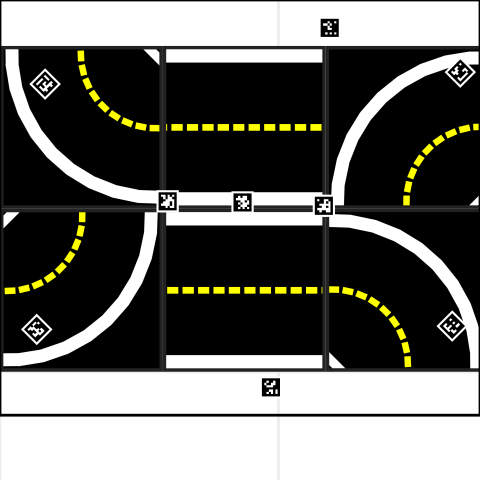

In [4]:
Map_Name = 'linus_loop'
m = dw.load_map(Map_Name)

print("The Map name is: \n" + Map_Name);
ipython_draw_svg(m, 'name');


In [5]:

logs_path = path.join(experiment_dir, '../data/BenchmarkXY/benchmarks/final')

localization_logs = [path.join(logs_path, f) for f in listdir(logs_path) if path.isfile(path.join(logs_path, f))]
print(f'Logs found: {localization_logs}')


compare_a = []
compare_b = []
enough_data_traj_a = True
enough_data_res_a = True
enough_data_traj_b = True
enough_data_res_b = True

i = 0
for filename in localization_logs:
    with open(filename, 'r') as file:
        if i == 0:
            name_a = filename
            compare_a.append(yaml.safe_load(file))
        if i == 1:
            name_b = filename
            compare_b.append(yaml.safe_load(file))
    i += 1

name_a = path.basename(name_a)    
if i == 2:
    do_comparison = True
    name_b = path.basename(name_b)
elif i == 1:
    do_comparison = False
    

Logs found: ['../data/BenchmarkXY/benchmarks/final/BAGNAME_benchmark_final_results.yaml', '../data/BenchmarkXY/benchmarks/final/BAGNAME_benchmark_final_results_2.yaml']


In [6]:
if do_comparison:
    if compare_a[0]['Benchmark_Type'] != compare_b[0]['Benchmark_Type']:
        print("This comparison won't work as the results come from two different Benchmarks")

The Benchmark type you are comparing is the following:

In [7]:
print(compare_a[0]['Benchmark_Type'])

Lane Following


The two Benchmark results you are about to compare are called:

In [8]:
db_data_a = compare_a[0]['db_data']
diag_toolbox_data_a = compare_a[0]['diag_toolbox_data']
if do_comparison:
    db_data_b = compare_b[0]['db_data']
    diag_toolbox_data_b = compare_b[0]['diag_toolbox_data']
    print("The two Benchmark results you are about to compare are called:")
    print(name_a + ' and ' + name_b)
    if db_data_a:
        if diag_toolbox_data_a:
            print("Benchmark A has data recorded of the diagnostic toolbox and of the Duckiebot directly")
        elif not diag_toolbox_data_a:
            print("Benchmark A has no data recorded of the diagnostic toolbox but he has data recorded of the \
            Duckiebot directly")
    elif not db_data_a:
        if diag_toolbox_data_a:
            print("Benchmark A has data recorded of the diagnostic toolbox bun none of the Duckiebot directly")
        elif not diag_toolbox_data_a:
            print("Benchmark A has no data recorded of the diagnostic toolbox and no data of the Duckiebot directly")
    
    if db_data_b:
        if diag_toolbox_data_b:
            print("Benchmark B has data recorded of the diagnostic toolbox and of the Duckiebot directly")
        elif not diag_toolbox_data_b:
            print("Benchmark B has no data recorded of the diagnostic toolbox but he has data recorded of the \
            Duckiebot directly")
    elif not db_data_b:
        if diag_toolbox_data_b:
            print("Benchmark B has data recorded of the diagnostic toolbox bun none of the Duckiebot directly")
        elif not diag_toolbox_data_b:
            print("Benchmark B has no data recorded of the diagnostic toolbox and no data of the Duckiebot directly")
else:
    print("The Benchmark you are about to score is called:")
    print(name_a)
    if db_data_a:
        if diag_toolbox_data_a:
            print("Your Benchmark has data recorded of the diagnostic toolbox and of the Duckiebot directly")
        elif not diag_toolbox_data_a:
            print("Your Benchmark has no data recorded of the diagnostic toolbox but he has data recorded of the Duckiebot directly")
    elif not db_data_a:
        if diag_toolbox_data_a:
            print("Your Benchmark has data recorded of the diagnostic toolbox bun none of the Duckiebot directly")
        elif not diag_toolbox_data_a:
            print("Your Benchmark has no data recorded of the diagnostic toolbox and no data of the Duckiebot directly")

The two Benchmark results you are about to compare are called:
BAGNAME_benchmark_final_results.yaml and BAGNAME_benchmark_final_results_2.yaml
Benchmark A has data recorded of the diagnostic toolbox and of the Duckiebot directly
Benchmark B has data recorded of the diagnostic toolbox and of the Duckiebot directly


In [9]:
if do_comparison:
    print("The actual performance of Benchmark A is based on {0} experiments whilst the performance of Benchmark B is based on {1}\
    experiments".format(compare_a[0]['Number of tests ran'],compare_b[0]['Number of tests ran']))
else:
    print("The actual performance of your is based on {0} experiments".format(compare_a[0]['Number of tests ran']))
    

The actual performance of Benchmark A is based on 2 experiments whilst the performance of Benchmark B is based on 2    experiments


In [10]:
if do_comparison:
    if compare_a[0]['Enough data traj wise']:
        if compare_a[0]['Enough data results wise']:
            enough_data_traj_a = True
            enough_data_res_a = True
            print("Benchmark A has ran enough experiments for an actual comparison")
        elif not compare_a[0]['Enough data results wise']:
            enough_data_traj_a = True
            enough_data_res_a = False
            print("Benchmark A has ran not enough experiments for an actual comparison of the results")
    elif not compare_a[0]['Enough data traj wise']:
        if compare_a[0]['Enough data results wise']:
            enough_data_traj_a = False
            enough_data_res_a = True
            print("Benchmark A has ran not enough experiments for an actual comparison of the trajectory")
        elif not compare_a[0]['Enough data results wise']:
            enough_data_traj_a = False 
            enough_data_res_a = False
            print("Benchmark A has ran not enough experiments for an actual comparison of the results nor trajectory")
  
    if compare_b[0]['Enough data traj wise']:
        if compare_b[0]['Enough data results wise']:
            enough_data_traj_b = True
            enough_data_res_b = True
            print("Benchmark B has ran enough experiments for an actual comparison")
        elif not compare_b[0]['Enough data results wise']:
            enough_data_traj_b = True
            enough_data_res_b = False
            print("Benchmark B has ran not enough experiments for an actual comparison of the results")
    elif not compare_b[0]['Enough data traj wise']:
        if compare_b[0]['Enough data results wise']:
            enough_data_traj_b = False
            enough_data_res_b = True
            print("Benchmark B has ran not enough experiments for an actual comparison of the trajectory")
        elif not compare_a[0]['Enough data results wise']:
            enough_data_traj_b = False
            enough_data_res_b = False
            print("Benchmark B has ran not enough experiments for an actual comparison of the results nor trajectory")
                  
else:
    if compare_a[0]['Enough data traj wise']:
        if compare_a[0]['Enough data results wise']:
            enough_data_traj_a = True
            enough_data_res_a = True
            print("Your Benchmark has ran enough experiments for an actual comparison")
        elif not compare_a[0]['Enough data results wise']:
            enough_data_traj_a = True
            enough_data_res_a = False
            print("Your Benchmark has ran not enough experiments for an actual comparison of the results")
    elif not compare_a[0]['Enough data traj wise']:
        if compare_a[0]['Enough data results wise']:
            enough_data_traj_a = False
            enough_data_res_a = True
            print("Your Benchmark has ran not enough experiments for an actual comparison of the trajectory")
        elif not compare_a[0]['Enough data results wise']:
            enough_data_traj_a = False 
            enough_data_res_a = False
            print("Your Benchmark has ran not enough experiments for an actual comparison of the results nor trajectory")
  
                  

Benchmark A has ran enough experiments for an actual comparison
Benchmark B has ran enough experiments for an actual comparison


In [11]:
if do_comparison:
    print("Below you see the Hardware Information received from the Hardware check of the two Benchmarks.\n\
    Please note that for a meaningful comparison they should be equal in all the keypoints. This should hold if you carefully followed the instructions of the Benchmark\n\
    The keypoints are: verdict, db_version, platform, hat_version, actuation and camera.")
else:
    print("Below you see the Hardware Information received from the Hardware check of your Benchmark.")

Below you see the Hardware Information received from the Hardware check of the two Benchmarks.
    Please note that for a meaningful comparison they should be equal in all the keypoints. This should hold if you carefully followed the instructions of the Benchmark
    The keypoints are: verdict, db_version, platform, hat_version, actuation and camera.


In [12]:
if do_comparison:
    print('Item\t\t\tBenchmark A\t\t\t\tBenchmark B')
    print('--------------------------------------------------------------------------------------')
    for item, doc in compare_a[0]['Engineering Data']['Performance']['HW_info'].items():
        res_a = str(doc).strip()
        res_b = str(compare_b[0]['Engineering Data']['Performance']['HW_info'][item]).strip()
        
        if item == 'item':
            continue
        elif item in ('verdict','country'):
            print(item+'\t\t\t'+res_a+'\t\t\t\t\t'+res_b)
        elif item in ('hostname','hat_version'):
            print(item+'\t\t'+res_a+'\t\t\t\t'+res_b)
        elif item in ('mac-adress','usb-memory'):
            print(item+'\t\t'+res_a+'\t\t\t'+res_b)
        elif item in ('date'):
            print(item+'\t\t\t'+res_a+'\t\t\t\t'+res_b)
        elif item in ('battery'):
            print(item+'\t\t\t'+res_a+'\t\t\t'+res_b)
        elif item in ('actuation'):
            print(item+'\t\t'+res_a+'\t'+res_b)
        elif item in ('camera'):
            print(item+'\t\t\t'+res_a+'\t\t'+res_b)
        else:
            print(item+'\t\t'+res_a+'\t\t\t\t\t'+res_b)
#         print(item + ':\t\t', doc, '\t\t\t\t\t', res_b)


else:
    print("Your Benchmark:")
    for item, doc in compare_a[0]['Engineering Data']['Performance']['HW_info'].items():
        print(item, ":", doc)
    

Item			Benchmark A				Benchmark B
--------------------------------------------------------------------------------------
verdict			True					True
hostname		autobot01				autobot01
db_version		DB18					DB18
date			2020-05-05				2020-05-05
country			CH					CH
institution		ETHZ					ETHZ
mac-adress		b8:27:eb:e2:65:35			b8:27:eb:e2:65:35
platform		RPI3B+					RPI3B+
hat_version		Duckiebot Hut				Duckiebot Hut
usb-memory		No USB memory detected!			No USB memory detected!
sd-memory		32GB					32GB
battery			Duckiebattery v. 1.0			Duckiebattery v. 1.0
actuation		DG01D dual-axis drive gear (48:1)	DG01D dual-axis drive gear (48:1)
wheel_type		Type 1					Type 1
camera			Waveshare Raspberry Pi Camera		Waveshare Raspberry Pi Camera
led_type		Type 1					Type 1
tester_name		Linus					Linus


In [13]:
if do_comparison:
    print("Lets now have a look at the performance of Benchmark A compared to B")
else:
    print("Let's now have a look at the results of your Benchmark")
    


Lets now have a look at the performance of Benchmark A compared to B


Please note that the localization of the Duckiebot that is measured by the watchtowers is with respect to the center of the April Tag that is placed on your Duckiebot.
This means that all kind of measurements and results that talk about the position of the Duckiebot are refering to the center of the April Tag on top of the Duckiebot. 

In the Benchmark we consider on one hand the actual performance of the code, which means the actual behaving, and on the other hand we consider the engineering data performance. The engineering data that was recorded during the Benchmark gives you an insight on the CPU usage, update frequency of the different nodes, the latency etc.

The metrics used here to generate a score are the following (please not that in brackets the priorities are noted, H = High priority, M = Medium priority and L = low priority:
1. Behaviour
    * Mean distance to the middle of the lane (H)
    * Mean heading offset compared to the reference heading (H)
    * Mean difference between the calculated offset by the Duckiebot and the actual offset calculated by the Watchtowers. (M)
    * Mean difference between the calculated heading error by the Duckiebot and the actual heading error calculated by the Watchtowers. (M)
    * % crashes (number of early stops due to slow driving or crashes devided by the number of experiments ran) (H)
    * Mean time until termination (L)
    * Mean time needed per tile (L)
    
2. Engineering data:
    * Mean latency (lag up to and including the detector node) (H)
    * Mean of the update frequency of the different nodes (H)
    * Mean of the CPU usage of the different containers (H)
    * Mean of the Memory usage of the different containers (L)
    * Mean of the nr of Threads of the different containers (L)
    * Overall CPU usage (H)
    * Overall Memory usage (M)
    * Overall SWAP usage (M)

But one step at a time.

First we have a look at the Hardware that was used for the two different benchmarks. If this Hardware has some major differences please not that your results might vary because of the Hardware difference. To check this please run a Hardware Benchmark.
Here it is assumed that you followed precisely the Behaviour Benchmarking instructions which will result in two identical and therefor well comparable Hardware set ups.


# Analyze Dashboard Data



Now we look at the Software that was used for the two Benchmarks, below you see the Containers that were running on the Duckiebots during the Benchmarks as well as their image names and tags, their base image, module type as well as their template name.


In [14]:
comp_diag = True
comp_db_dat = True


    
if diag_toolbox_data_a and diag_toolbox_data_b:
    comp_diag = True
    print("Luckely both Benchmarks have recorded data from the diagnostic toolbox which means the two Benchmarks can\
    be compared based on this measured engineering/performance data.")
else:
    comp_diag = False
    print("Unfortunately, one of the Benchmarks does not have data recorded from the Diagnostic Toolbox,\
    therefor there won't be a comparison in this field. If your new Benchmark does have data recorded from the\
    diagnostic toolbox and the one you are comparing it with does not, please just upload your Benchmark\
    results and run through this Notebook to get some idea about the score of you performance.")
    
if db_data_a and db_data_b:
    comp_db_dat = True
    print("Luckely both Benchmarks have recorded data from the Duckiebot directly which means the two Benchmarks can \
    be compared based those measurements.")
else:
    comp_db_dat = False
    print("Unfortunately, one of the Benchmarks does not have data recorded from the Duckiebot directly,\
    therefor there won't be a comparison in this field. If your new Benchmark does have data recorded from the\
    diagnostic toolbox and the one you are comparing it with does not, please just upload your Benchmark\
    results and run through this Notebook to get some idea about the score of you performance.")

Luckely both Benchmarks have recorded data from the diagnostic toolbox which means the two Benchmarks can    be compared based on this measured engineering/performance data.
Luckely both Benchmarks have recorded data from the Duckiebot directly which means the two Benchmarks can     be compared based those measurements.


In [15]:
if do_comparison and comp_diag:
    print("Benchmark A:")
    for cont,inf in compare_a[0]['Engineering Data']['Static']['Dashboard Info'].items():
        if cont!= 'Container Name':
            print(cont+':')
            for infn in inf:
                if infn in ('Image Name', 'Image Tag','DT label base image','DT label module type','DT label template name'):
                    print('\t'+infn+': '+inf[infn])
    print('--------------------------------------------------------------------------------------------------------------')
    print("Benchmark B:")
    for cont,inf in compare_b[0]['Engineering Data']['Static']['Dashboard Info'].items():
        if cont!= 'Container Name':
            print(cont+':')
            for infn in inf:
                if infn in ('Image Name', 'Image Tag','DT label base image','DT label module type','DT label template name'):
                    print('\t'+infn+': '+inf[infn])
elif not do_comparison:
    print("Your Benchmark:")
    for cont,inf in compare_a[0]['Engineering Data']['Static']['Dashboard Info'].items():
        if cont!= 'Container Name':
            print(cont+':')
            for infn in inf:
                if infn in ('Image Name', 'Image Tag','DT label base image','DT label module type','DT label template name'):
                    print('\t'+infn+': '+inf[infn])
else:
    print("unfortunately this comparison can not be made as one of the Benchmakrks does not have this information")

Benchmark A:
dts-run-diagnostics-system-monitor:
	Image Name: duckietown/dt-system-monitor:daffy-arm32v7
	Image Tag: sha256:a4ff6718a1686c11d92ac439bc19e1162c34ae8396fc4d77782f550c5b21080a
	DT label base image: dt-commons:daffy-arm32v7
	DT label module type: dt-system-monitor
	DT label template name: template-basic
cocky_banach:
	Image Name: proj-parking:light
	Image Tag: sha256:7a42875db0688dace79586a045e620dbf892d1553a97dd6a7ac3d68e7bb618fe
	DT label base image: dt-ros-commons:daffy-arm32v7
	DT label module type: dt-core
	DT label template name: template-ros
demo_all_drivers:
	Image Name: duckietown/dt-duckiebot-interface:daffy
	Image Tag: sha256:0bd696e5a9d9f22c17e0d022f04c3cdfca1c66e68751abe9d546e5ff18b24880
	DT label base image: dt-ros-commons:daffy-arm32v7
	DT label module type: dt-duckiebot-interface
	DT label template name: template-ros
acquisition-bridge:
	Image Name: duckietown/acquisition-bridge:daffy-arm32v7
	Image Tag: sha256:ea2b9feccb29e23f6ca16cc4b324aa2d070dc41ad72555c

Now lets have a look at the constats that were set when the experiments were ran

In [16]:
if do_comparison and comp_diag:
    print('Constant\tBenchmark A\t\tBenchmark B')
    print('--------------------------------------------------------------------------------------')
    for item, doc in compare_a[0]['Engineering Data']['Static']['Constants'].items():
        res_a = str(doc).strip()
        res_b = str(compare_b[0]['Engineering Data']['Static']['Constants'][item]).strip()
        
        if item in ('omega_max','baseline'):
            print(item + ':\t', res_a, '\t\t', res_b)
        else:
            print(item + ':\t\t', res_a, '\t\t', res_b)
        


elif not do_comparison:
    print("Your Benchmark:")
    for item, doc in compare_a[0]['Engineering Data']['Performance']['HW_info'].items():
        print(item, ":", doc)
        
else:
    print("unfortunately this comparison can not be made as one of the Benchmakrks does not have this information")

Constant	Benchmark A		Benchmark B
--------------------------------------------------------------------------------------
trim:		 ['0.0'] 		 ['0.0']
v_max:		 ['1.0'] 		 ['1.0']
radius:		 ['0.0318'] 		 ['0.0318']
gain:		 ['1.0'] 		 ['1.0']
omega_max:	 ['8.0'] 		 ['8.0']
limit:		 ['1.0'] 		 ['1.0']
k:		 ['27.0'] 		 ['27.0']
baseline:	 ['0.1'] 		 ['0.1']


Below you can see the overall CPU, SWAP and Memory usage of the two benchmarks compared to each other. Please note that the mean is of the corresponding measurements are shown as the usages don't change significantly over the time of the Benchmark.

For the Benchmark A the Diagnostic Toolbox ran 2 times whilst doing the experiments    compared to Benchmark B where the Diagnostic Toolbox ran 2.


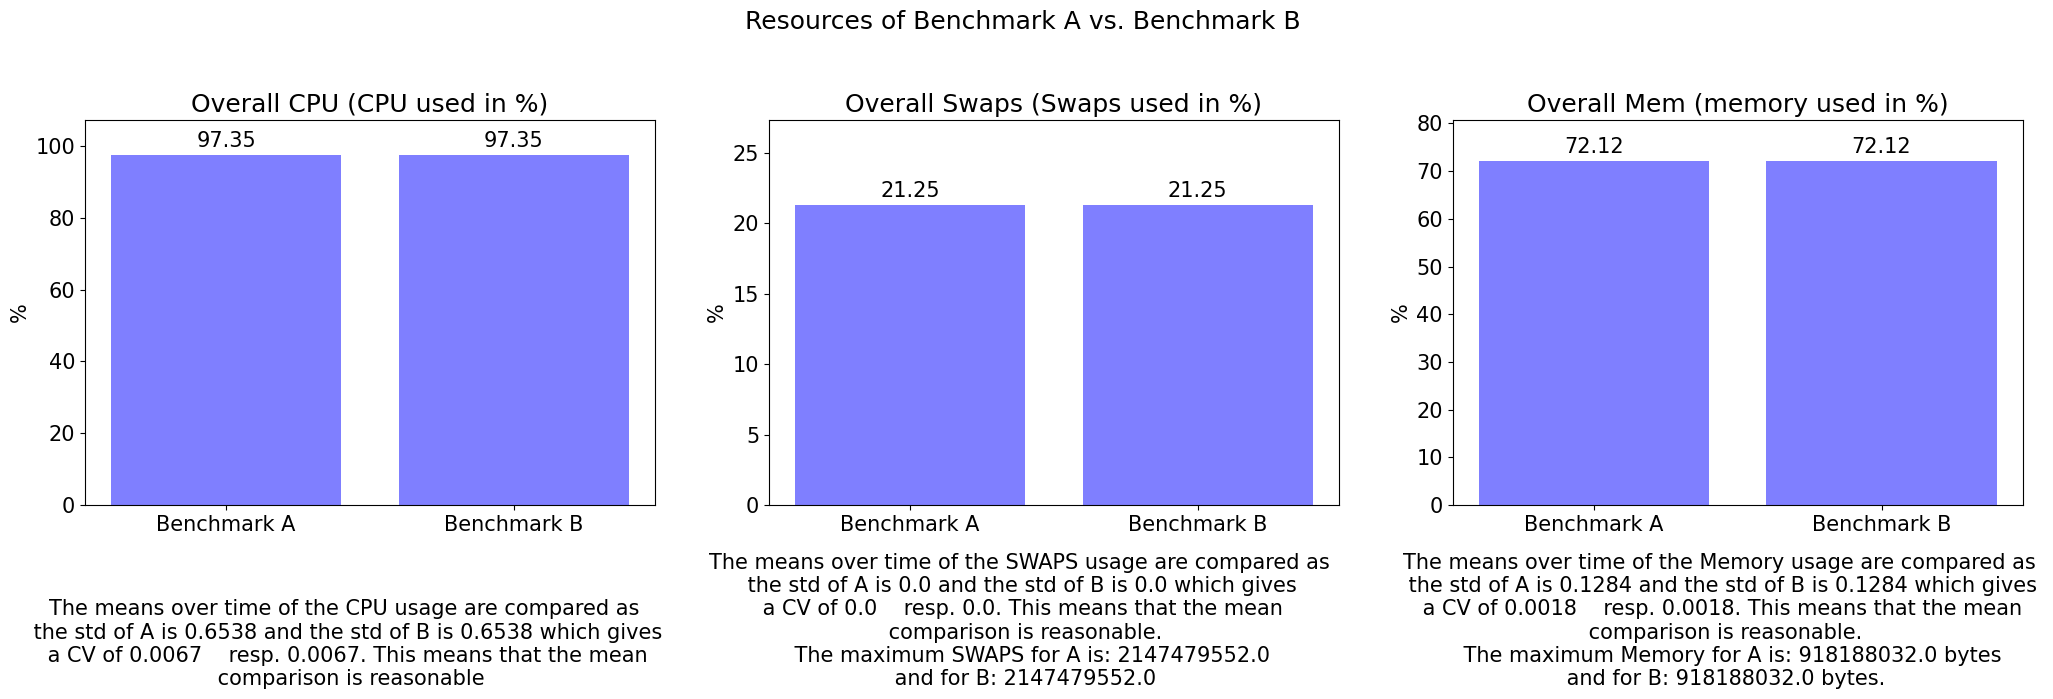

In [91]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = float(np.round(rect.get_height(),2))
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

if do_comparison and comp_diag:
    fil_used_diag_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data container']\
    ['Nb of files']
    fil_used_diag_b = compare_b[0]['Engineering Data']['Performance']['Total engineering data container']\
    ['Nb of files']
    print("For the Benchmark A the Diagnostic Toolbox ran {0} times whilst doing the experiments\
    compared to Benchmark B where the Diagnostic Toolbox ran {1}.".format(fil_used_diag_a,fil_used_diag_b))

    plt.rcParams.update({'font.size': 15})
    fig, axes = plt.subplots(nrows=1, ncols=3)
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle('Resources of Benchmark A vs. Benchmark B', y=1.1)
    objects = ('Benchmark A', 'Benchmark B')
    
    x_pos = np.arange(len(objects))
    count = 0
    for cont,inf in compare_a[0]['Engineering Data']['Performance']['Total engineering data container']\
    ['Measurements']['Overall engineering data container'].items():
        performance = [inf['Mean'],\
                       compare_b[0]['Engineering Data']['Performance']['Total engineering data container']\
                       ['Measurements']['Overall engineering data container'][cont]['Mean']]
        if performance[0] < performance[1]:
            advantages.update({cont: 'A'})
            winner_color = ['green', 'red']
        elif performance[0] > performance[1]:
            advantages.update({cont: 'B'})
            winner_color = ['red', 'green']
        elif performance[0] == performance[1]:
            advantages.update({cont: 'equal'})
            winner_color = ['blue', 'blue']   
        else:
            winner_color = ['black', 'black']
        ax = axes.flatten()[count]
        rec = ax.bar(x_pos, performance, align='center', alpha=0.5, color=winner_color)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(objects)
        ax.set_ylabel('%')
        ax.set_title(cont)
        
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom, top+5)  
        
        autolabel(rec)
        count+=1

    cpu_std_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall CPU (CPU used in %)']['Standard Deviation']
    cpu_std_b = compare_b[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall CPU (CPU used in %)']['Standard Deviation']
    cv_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall CPU (CPU used in %)']['coefficient of variation']
    cv_b = compare_b[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall CPU (CPU used in %)']['coefficient of variation']
    cpu_txt= 'The means over time of the CPU usage are compared as \n the std of A is {0} and the std of B is {1} which gives \n a CV of {2}\
    resp. {3}. This means that the mean \n comparison is reasonable'.format(cpu_std_a,cpu_std_b,cv_a,cv_b)
    fig.text(.23, -.25, cpu_txt, ha='center')    

    swaps_std_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall Swaps (Swaps used in %)']['Standard Deviation']
    swaps_std_b = compare_b[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall Swaps (Swaps used in %)']['Standard Deviation']
    cv_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall Swaps (Swaps used in %)']['coefficient of variation']
    cv_b = compare_b[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall Swaps (Swaps used in %)']['coefficient of variation']
    swaps_max_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall Swaps (Swaps used in %)']['Swaps max']
    swaps_max_b = compare_b[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall Swaps (Swaps used in %)']['Swaps max']
    swaps_txt= 'The means over time of the SWAPS usage are compared as \n the std of A is {0} and the std of B is {1} which gives \n a CV of {2}\
    resp. {3}. This means that the mean \n comparison is reasonable.\n\
    The maximum SWAPS for A is: {4} \n and for B: {5}'.format(swaps_std_a,swaps_std_b,cv_a,cv_b,swaps_max_a,swaps_max_b)
    fig.text(.5, -.25, swaps_txt, ha='center')    

    mem_std_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall Mem (memory used in %)']['Standard Deviation']
    mem_std_b = compare_b[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall Mem (memory used in %)']['Standard Deviation']
    cv_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall Mem (memory used in %)']['coefficient of variation']
    cv_b = compare_b[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall Mem (memory used in %)']['coefficient of variation']
    mem_max_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall Mem (memory used in %)']['Memory Max (bytes)']
    mem_max_b = compare_b[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall Mem (memory used in %)']['Memory Max (bytes)']
    mem_txt= 'The means over time of the Memory usage are compared as \n the std of A is {0} and the std of B is {1} which gives \n a CV of {2}\
    resp. {3}. This means that the mean \n comparison is reasonable.\n\
    The maximum Memory for A is: {4} bytes \n and for B: {5} bytes.'.format(mem_std_a,mem_std_b,cv_a,cv_b,mem_max_a,mem_max_b)
    fig.text(.78, -.25, mem_txt, ha='center')    




    fig.set_figheight(5)
    fig.set_figwidth(25)

elif not do_comparison:
    fil_used_diag = compare_a[0]['Engineering Data']['Performance']['Total engineering data container']['Nb of files']
    print("For the your Benchmark the Diagnostic Toolbox ran {0} times whilst doing the experiments.".format(fil_used_diag))

    plt.rcParams.update({'font.size': 15})
    fig, axes = plt.subplots(nrows=1, ncols=3)
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle('Resources of your Benchmark', y=1.1)
    objects = ('Your Benchmark')
    x_pos = np.arange(1)
    count = 0
    winner_color = ['green', 'red']
    for cont,inf in compare_a[0]['Engineering Data']['Performance']['Total engineering data container']\
    ['Measurements']['Overall engineering data'].items():
        ax = axes.flatten()[count]
        ax.bar(x_pos, inf['Mean'], align='center', alpha=0.5, color=winner_color)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(objects)
        ax.set_ylabel('%')
        ax.set_title(cont)
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom, top+5) 
        autolabel(rec)
        count+=1

    cpu_std_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall CPU (CPU used in %)']['Standard Deviation']
    cv_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall CPU (CPU used in %)']['coefficient of variation']
    cpu_txt= 'The means  of the CPU usage are compared as the std \n of your BM is {0} which gives \n a CV of {1}\
    . This means that the mean \n comparison is reasonable'.format(cpu_std_a,cv_a)
    fig.text(.23, -.2, cpu_txt, ha='center')    

    swaps_std_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall Swaps (Swaps used in %)']['Standard Deviation']
    cv_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall Swaps (Swaps used in %)']['coefficient of variation']
    swaps_max = compare_b[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall Swaps (Swaps used in %)']['Swaps max']
    swaps_txt= 'The means  of the SWPAS usage are compared as the std \n of your BM is {0} which gives \n a CV of {1}\
    . This means that the mean \n comparison is reasonable.\n\
     The maximum SWAPS is: {2} bytes'.format(swaps_std_a,cv_a,swaps_max)
    fig.text(.5, -.2, swaps_txt, ha='center')    

    mem_std_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall Mem (memory used in %)']['Standard Deviation']
    cv_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall Mem (memory used in %)']['coefficient of variation']
    mem_max = compare_b[0]['Engineering Data']['Performance']['Total engineering data container']['Measurements']\
    ['Overall engineering data container']['Overall Mem (memory used in %)']['Memory Max (bytes)']
    mem_txt= 'The means  of the Memory usage are compared as the std \n of your BM is {0} which gives \n a CV of {1}\
    . This means that the mean \n comparison is reasonable.\n\
     The maximum Memory is: {2} bytes'.format(mem_std_a,cv_a,mem_max)
    
    fig.text(.78, -.2, mem_txt, ha='center')    




    fig.set_figheight(5)
    fig.set_figwidth(25)
    
else:
    print("unfortunately this comparison can not be made as one of the Benchmakrks does not have this information")

Now lets have a close look at the different nodes of the dt-core that were observed by the Diagnostic Toolbox, for each node the two Benchmarks are compared based on the CPU usage, the number of threads used as well as the Memory usage.
We compare the means as the neither of the above mentioned resources show a significant change over the time in which the experiments were running.

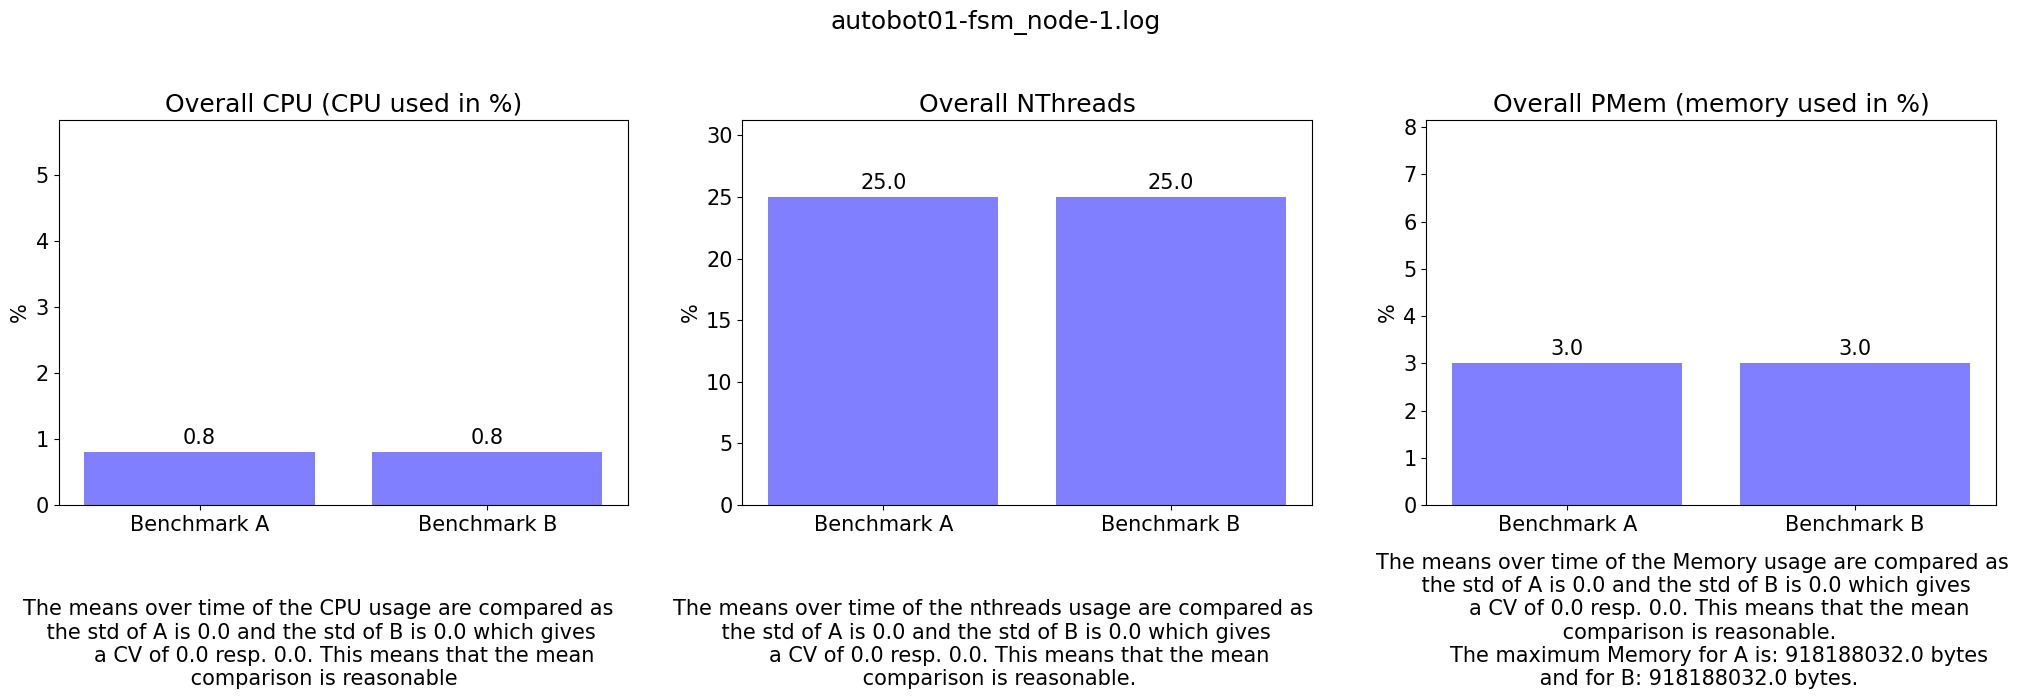

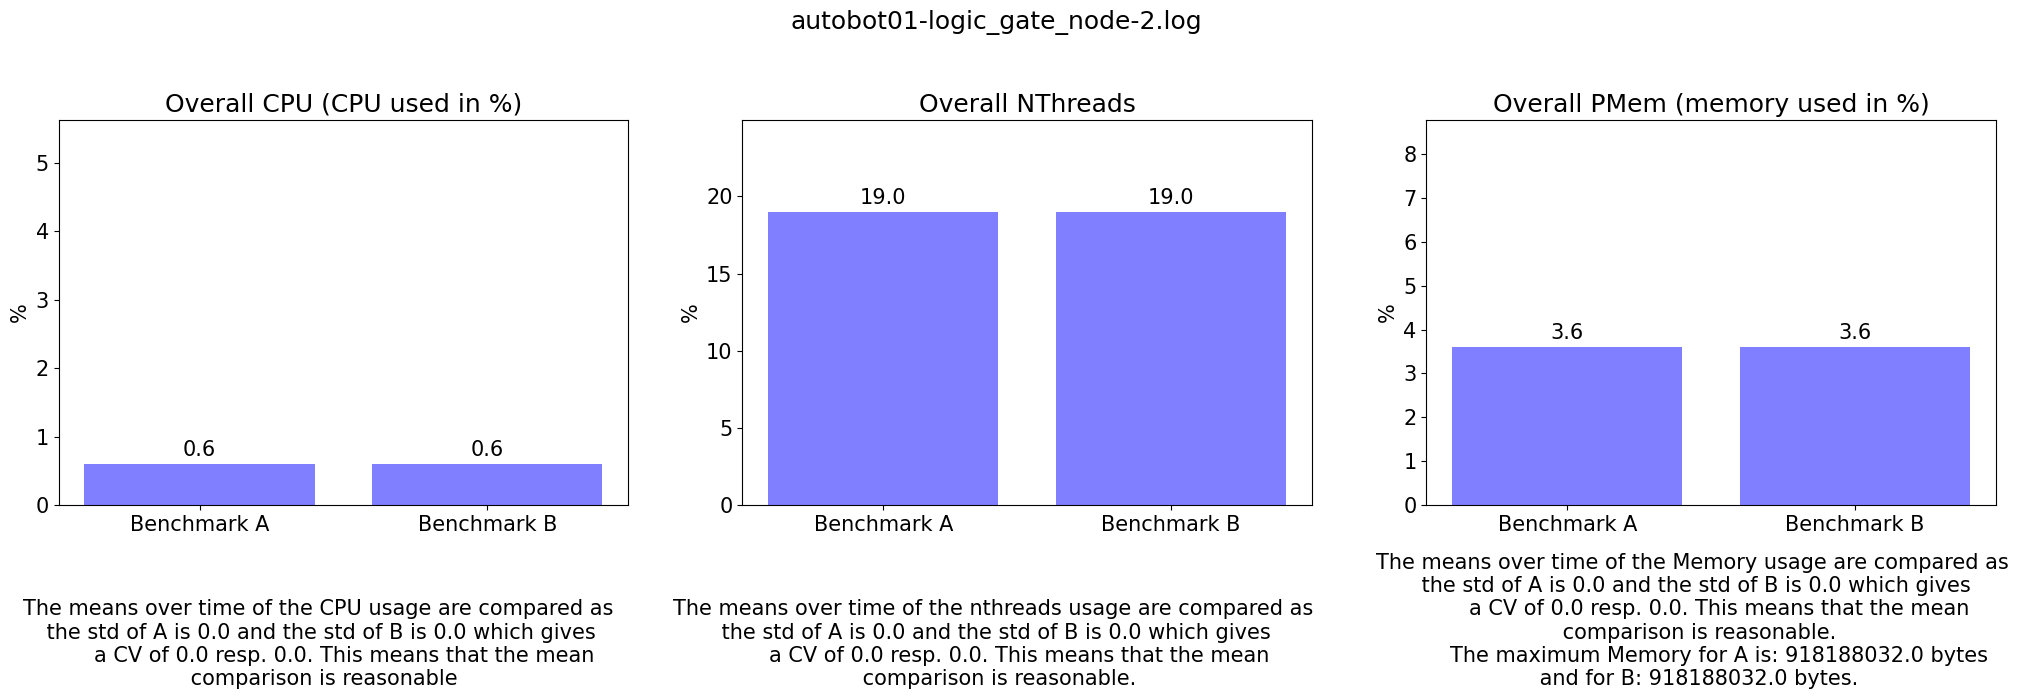

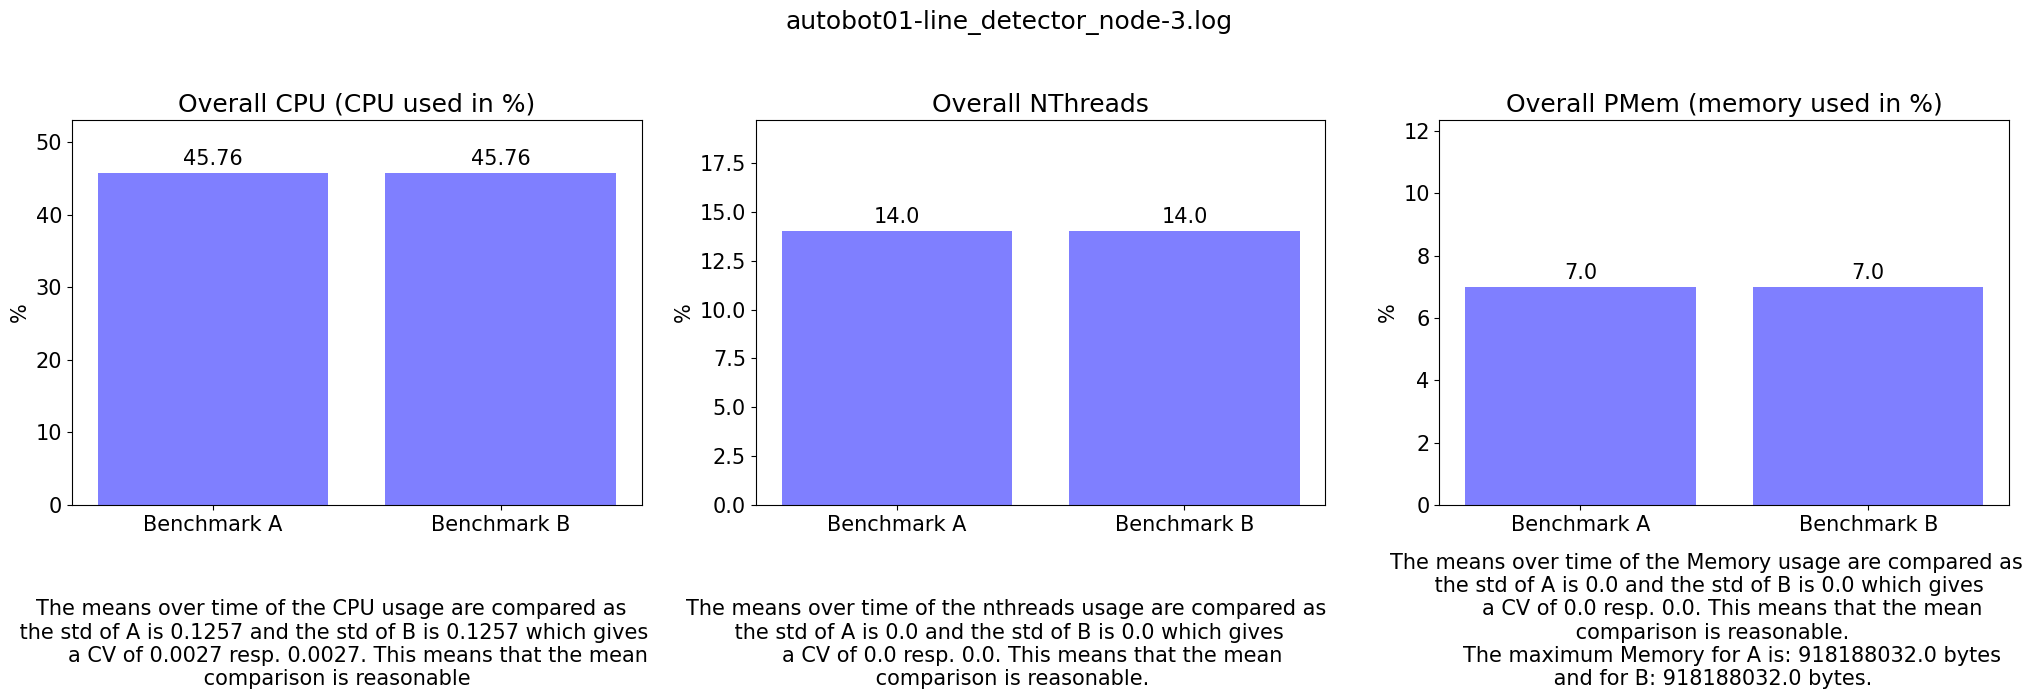

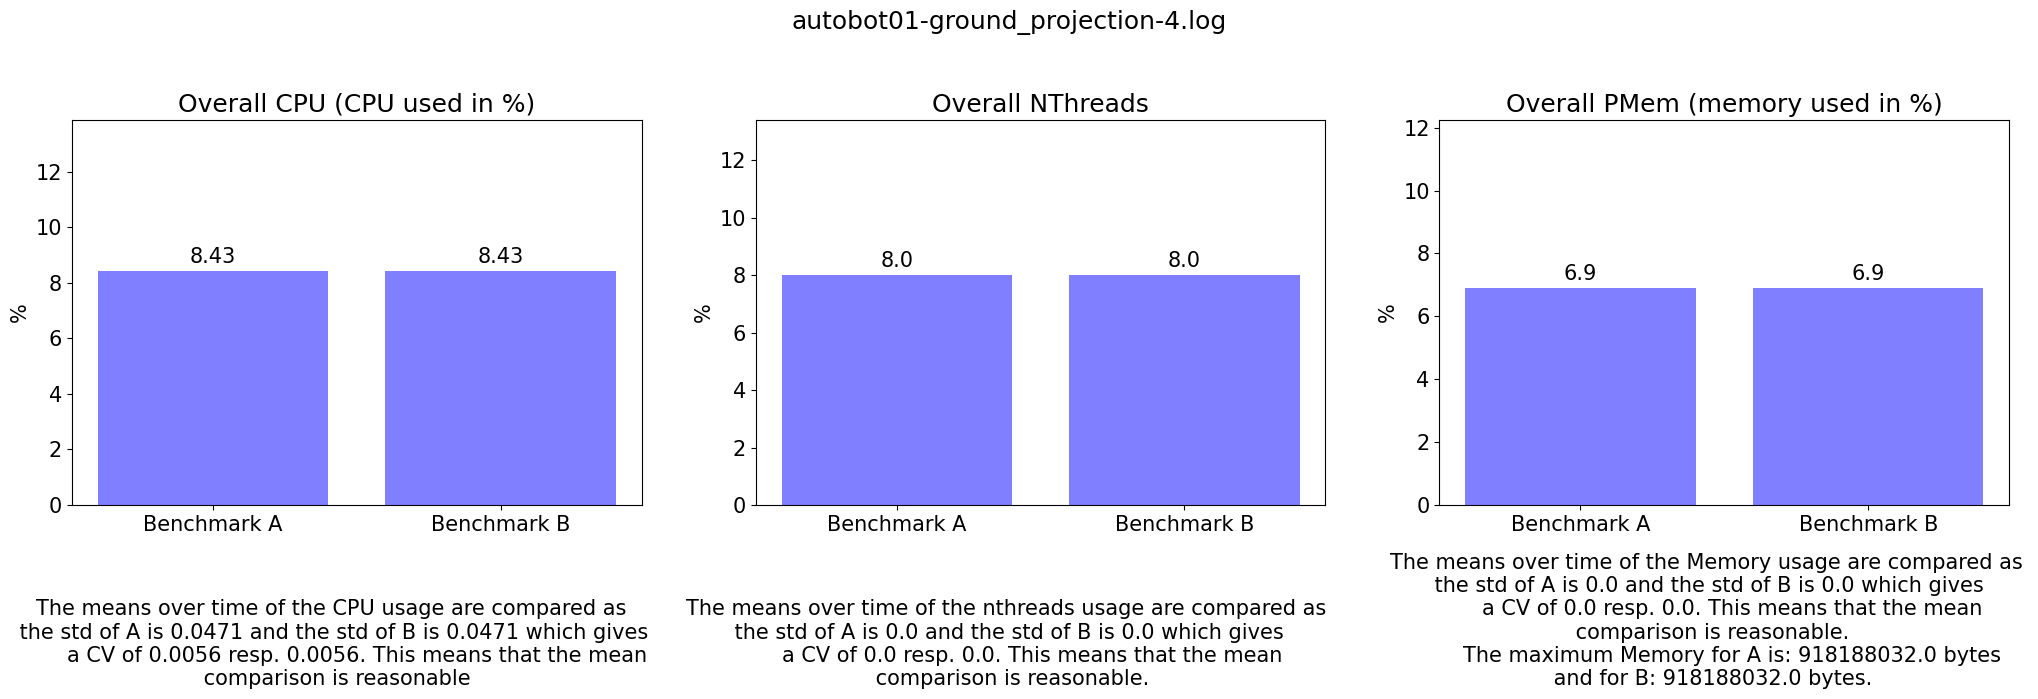

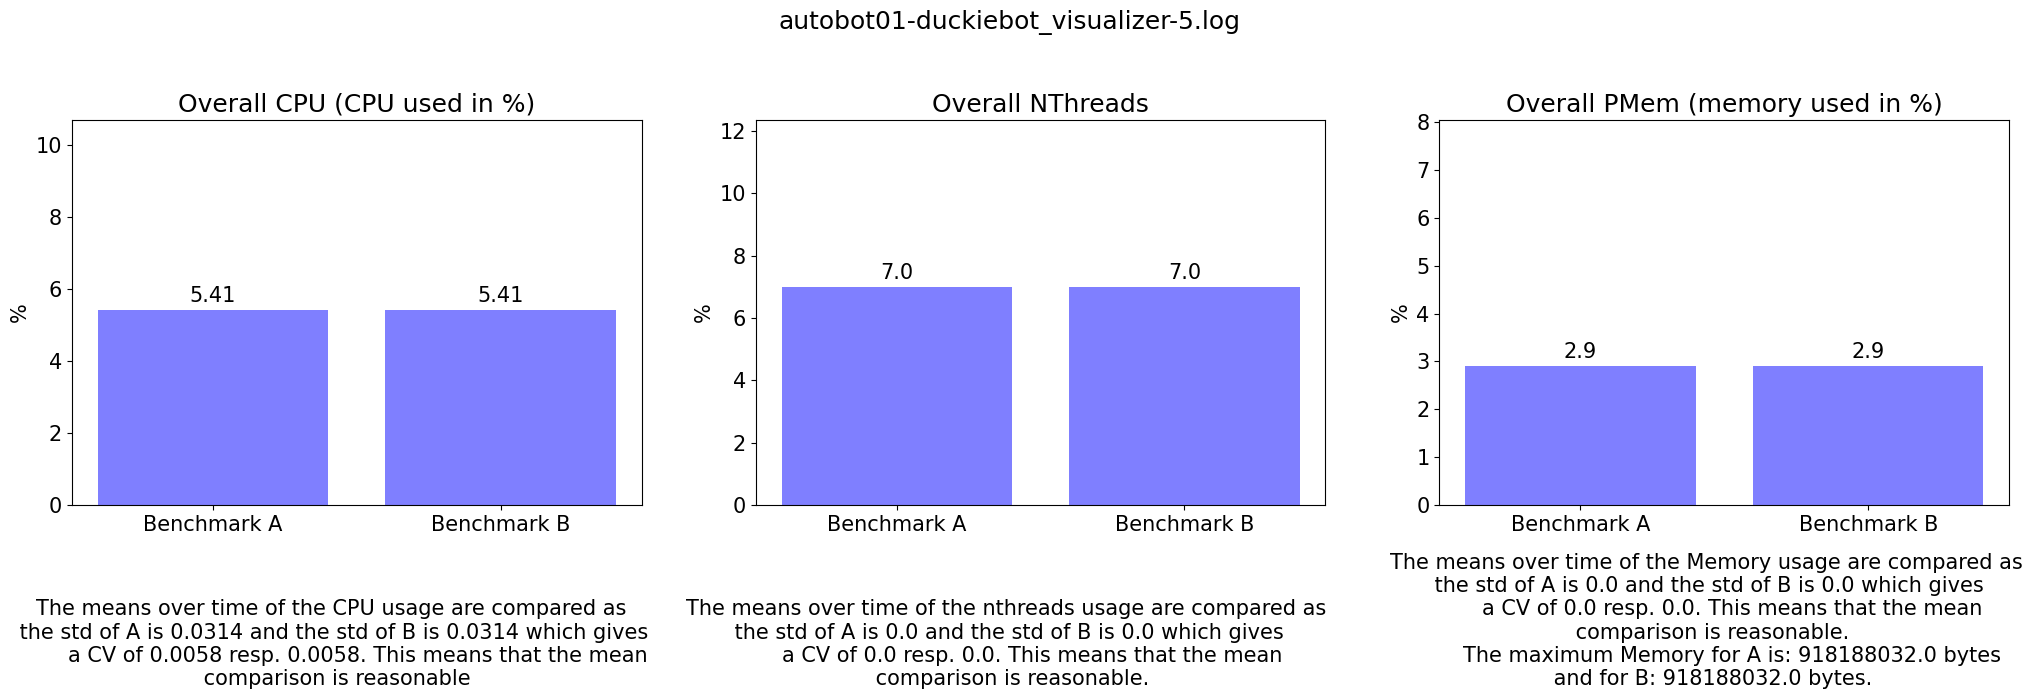

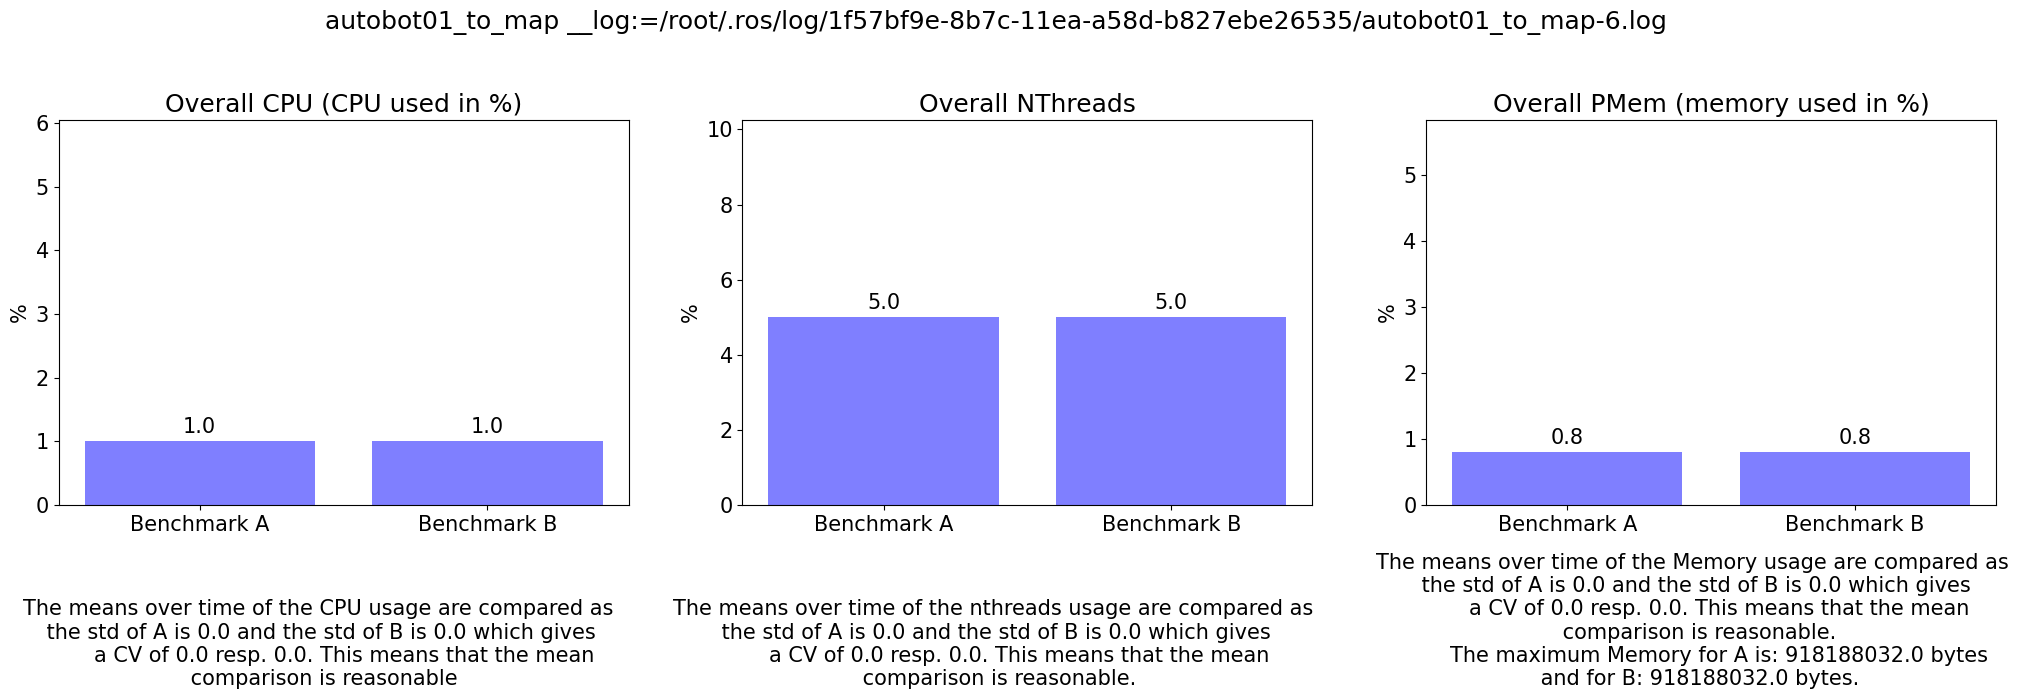

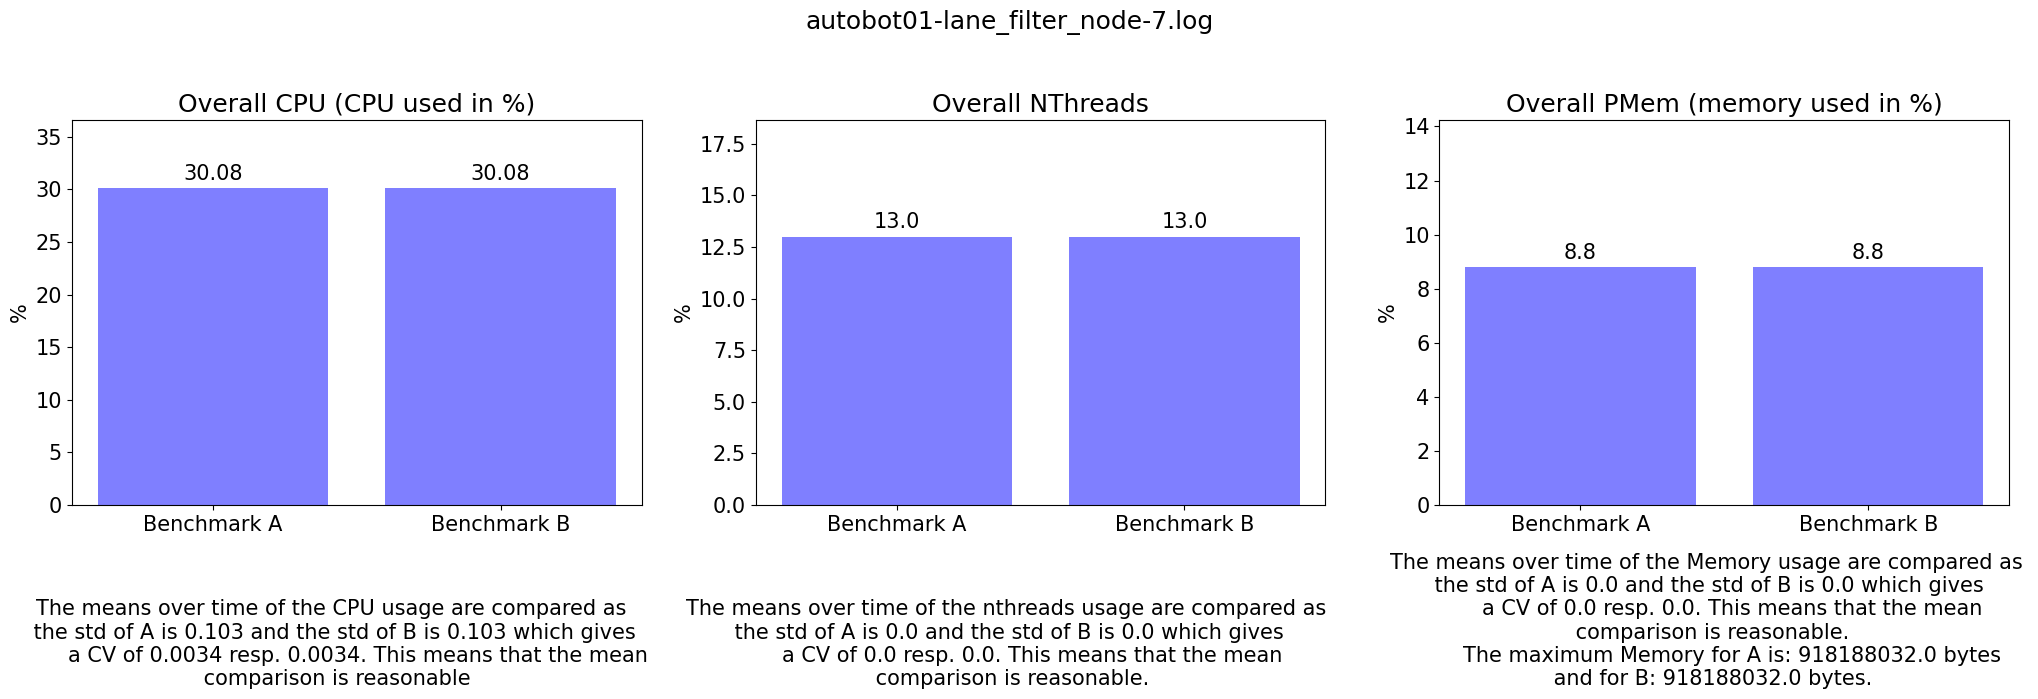

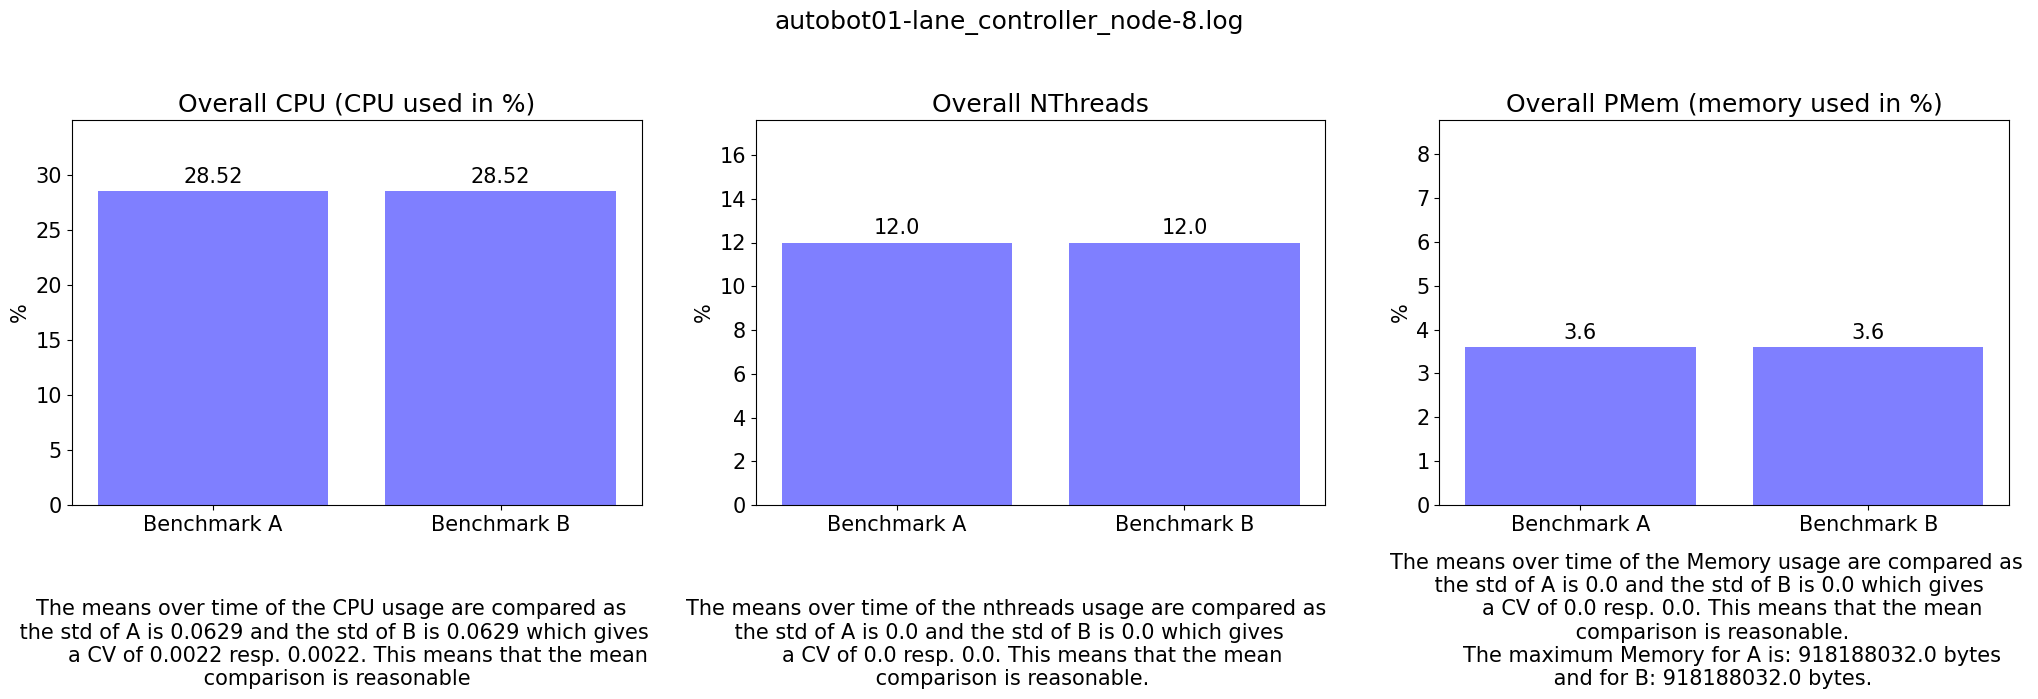

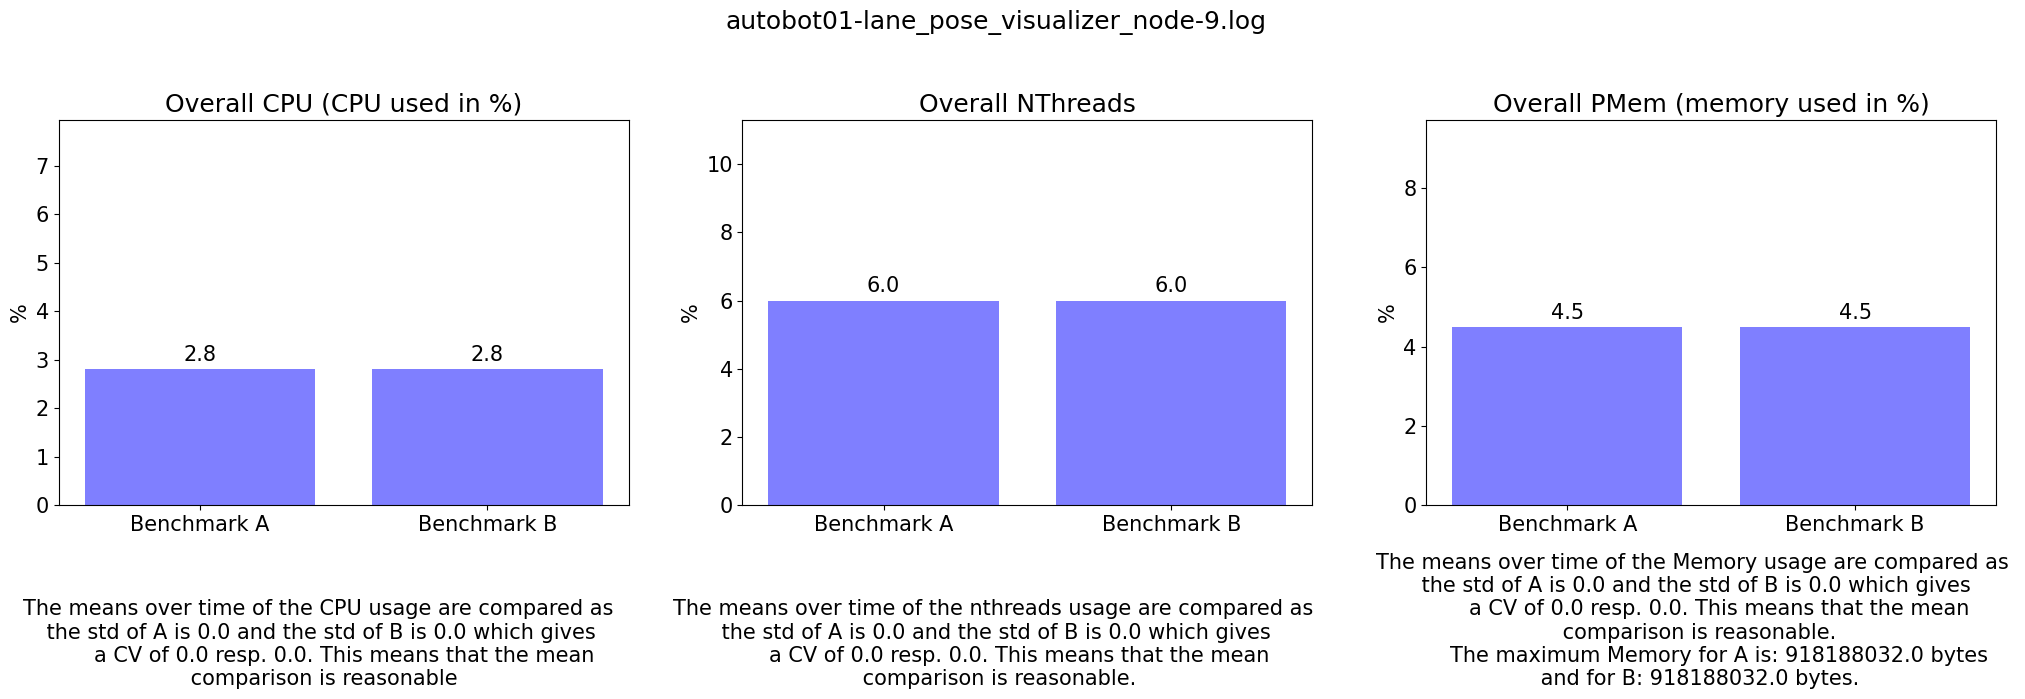

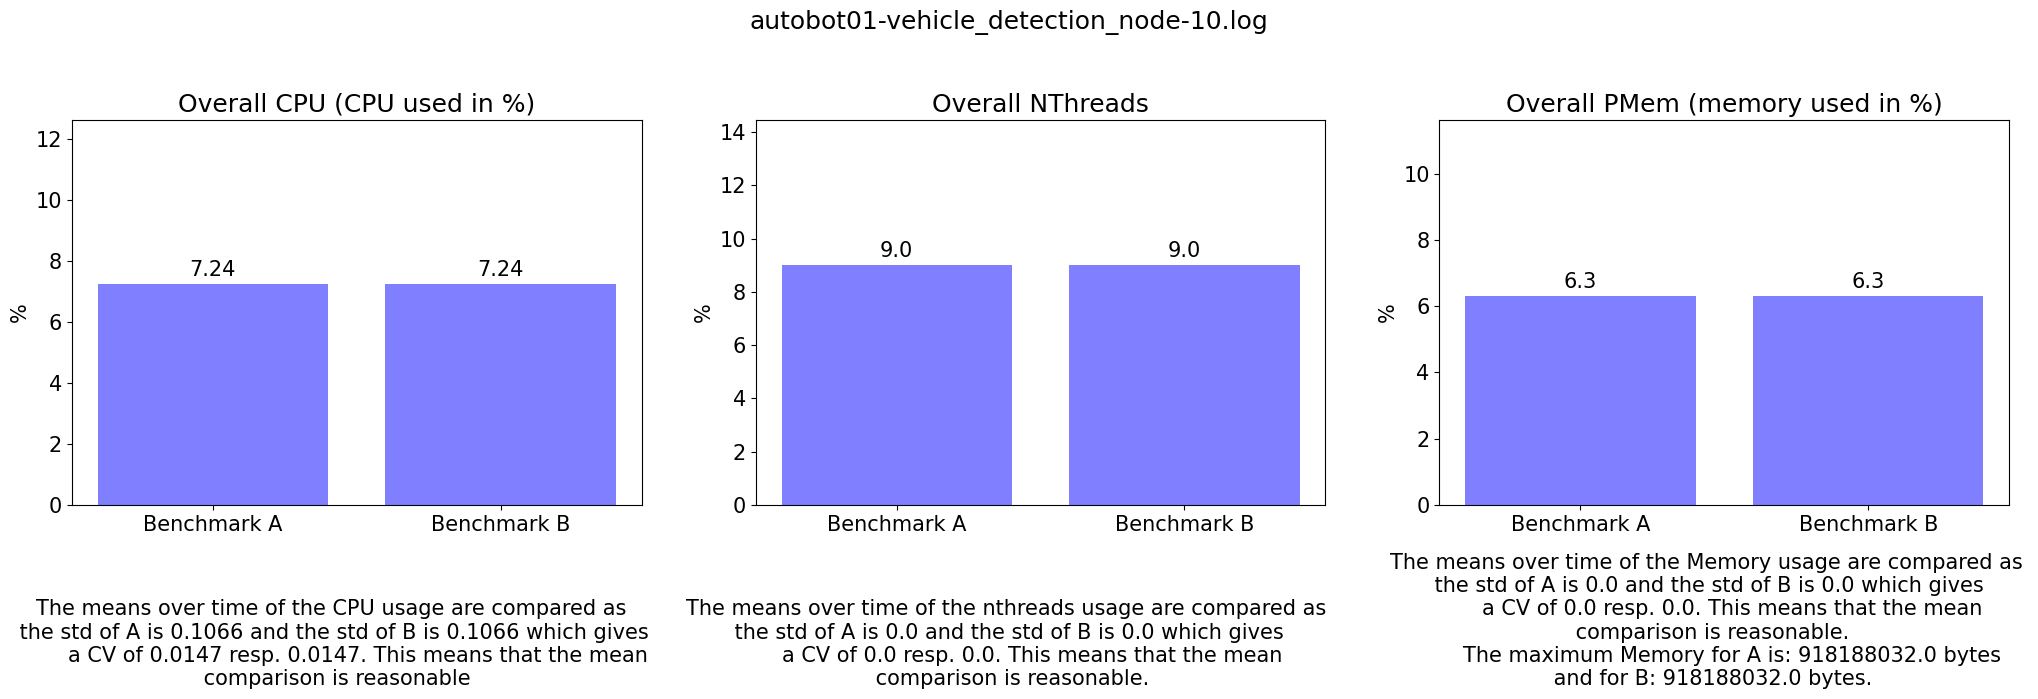

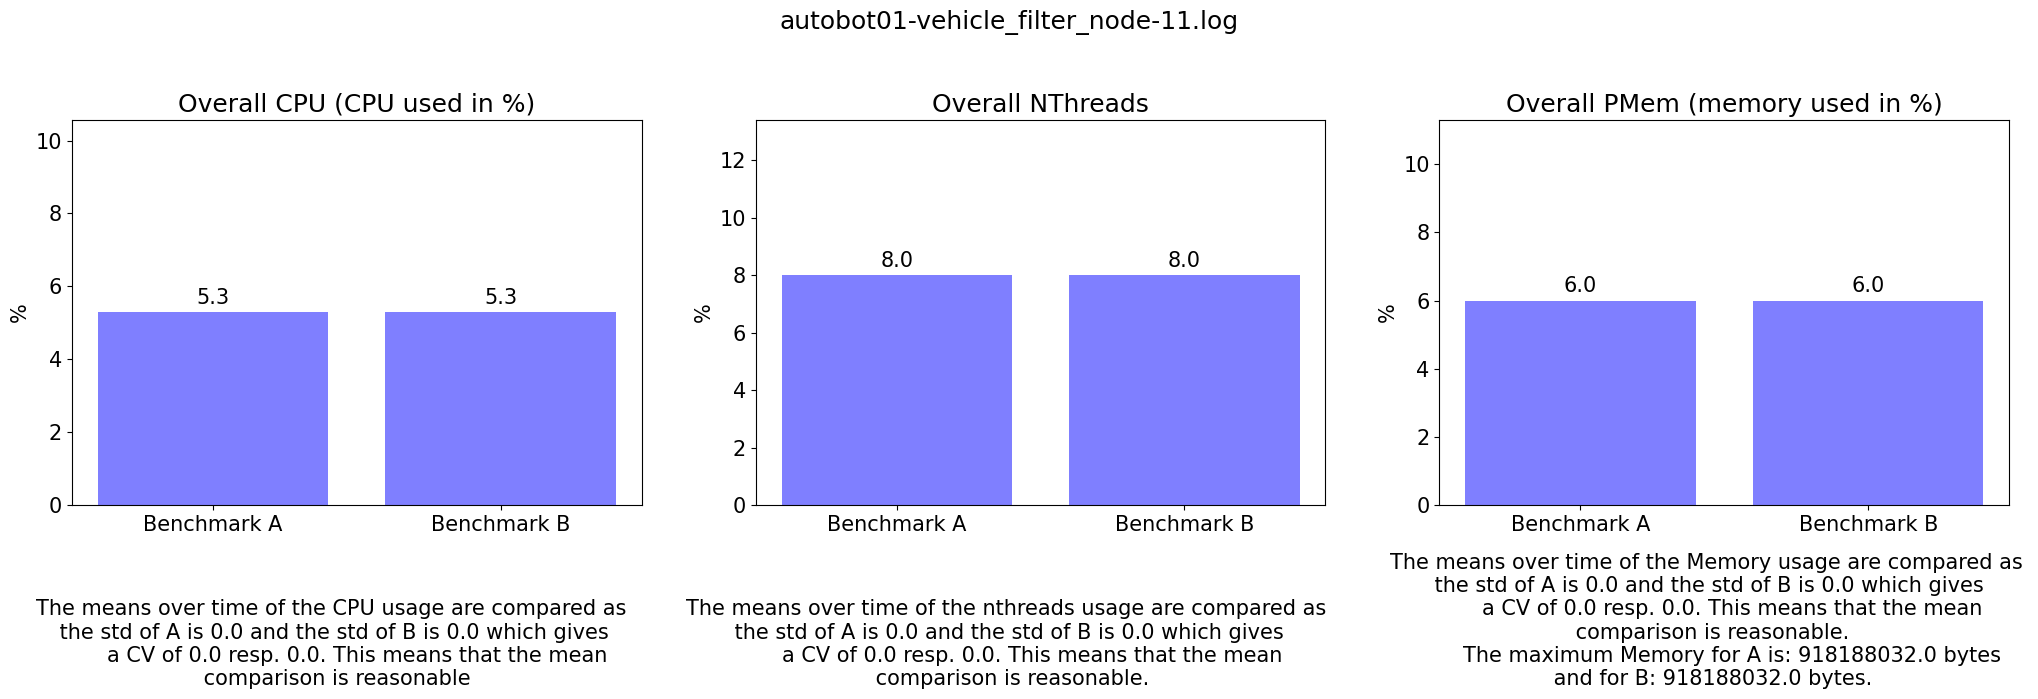

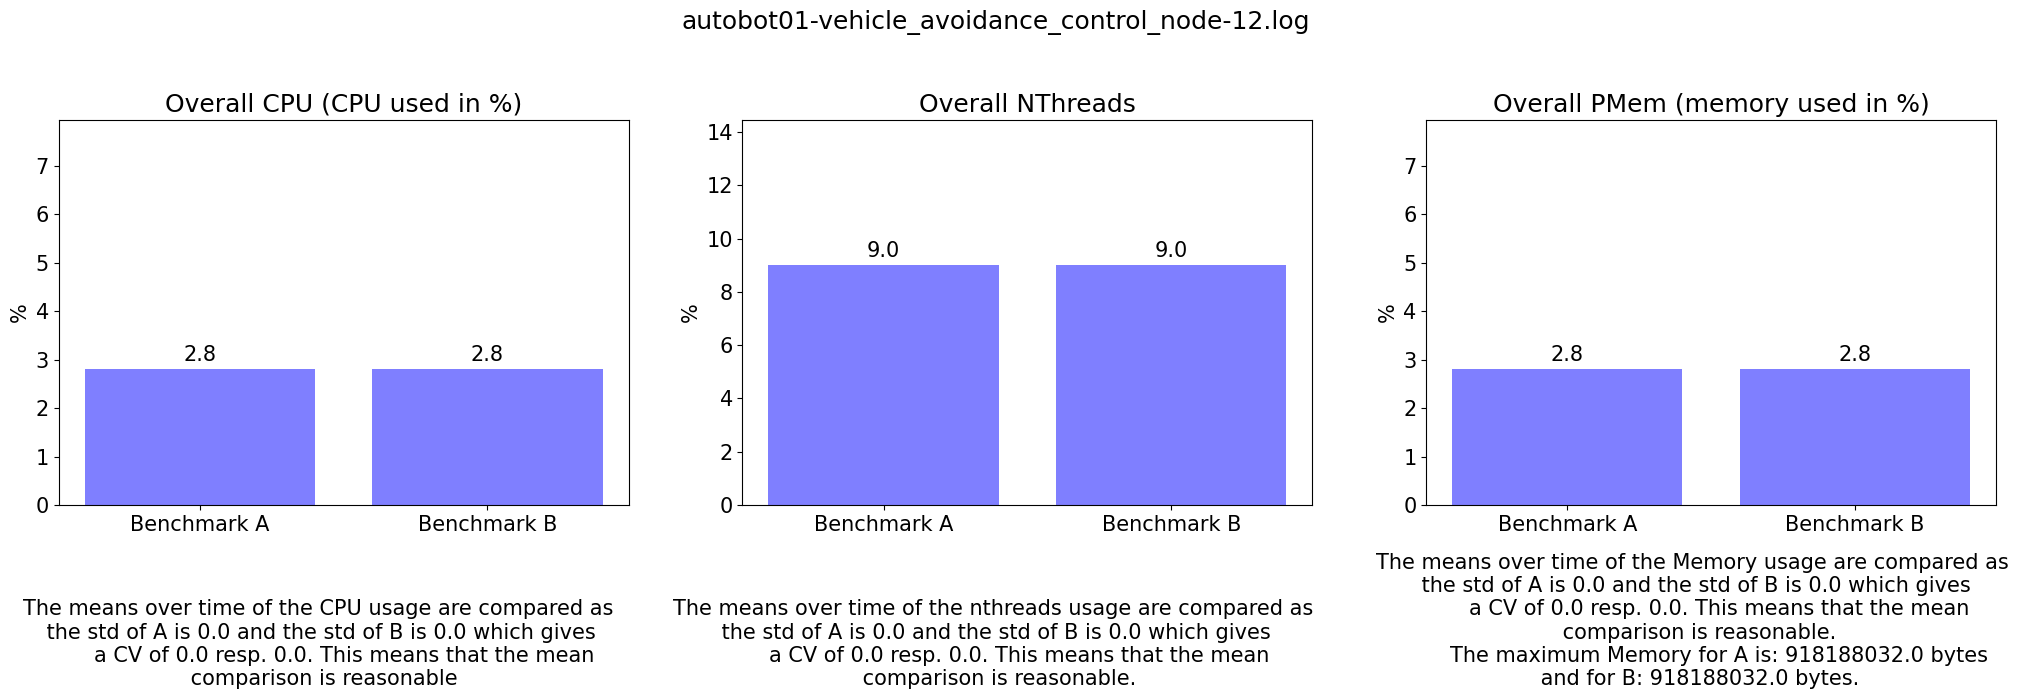

In [92]:
for node, meas in compare_a[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']['Overall engineering data node'].items():
    if do_comparison and comp_diag:
        plt.rcParams.update({'font.size': 15})
        fig, axes = plt.subplots(nrows=1, ncols=3)
        fig.subplots_adjust(hspace=0.5)
        fig.suptitle(node, y=1.1)
        objects = ('Benchmark A', 'Benchmark B')
        x_pos = np.arange(len(objects))
        count = 0


        for cont,inf in compare_a[0]['Engineering Data']['Performance']['Total engineering data node']\
        ['Measurements']['Overall engineering data node'][node].items():
            performance = [inf['Mean'],\
                           compare_b[0]['Engineering Data']['Performance']['Total engineering data node']\
                           ['Measurements']['Overall engineering data node'][node][cont]['Mean']]
            if performance[0] < performance[1]:
                advantages.update({node: 'A'})
                winner_color = ['green', 'red']
            elif performance[0] > performance[1]:
                advantages.update({node: 'B'})
                winner_color = ['red', 'green']
            elif performance[0] == performance[1]:
                advantages.update({node: 'equal'})
                winner_color = ['blue', 'blue']   
            else:
                winner_color = ['black', 'black']
            ax = axes.flatten()[count]
            rec = ax.bar(x_pos, performance, align='center', alpha=0.5, color=winner_color)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(objects)
            ax.set_ylabel('%')
            ax.set_title(cont)

            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom, top+5) 
            autolabel(rec)
            count+=1

        cpu_std_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall CPU (CPU used in %)']['Standard Deviation']
        cpu_std_b = compare_b[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall CPU (CPU used in %)']['Standard Deviation']
        cv_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall CPU (CPU used in %)']['coefficient of variation']
        cv_b = compare_b[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall CPU (CPU used in %)']['coefficient of variation']
        cpu_txt= 'The means over time of the CPU usage are compared as \n the std of A is {0} and the std of B is {1} which gives \n\
        a CV of {2} resp. {3}. This means that the mean \n comparison is reasonable'.format(cpu_std_a,cpu_std_b,cv_a,cv_b)
        fig.text(.23, -.25, cpu_txt, ha='center')

        nthreads_std_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall NThreads']['Standard Deviation']
        nthreads_std_b = compare_b[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall NThreads']['Standard Deviation']
        cv_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall NThreads']['coefficient of variation']
        cv_b = compare_b[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall NThreads']['coefficient of variation']
        nthreads_txt= 'The means over time of the nthreads usage are compared as \n the std of A is {0} and the std of B is {1} which gives \n\
        a CV of {2} resp. {3}. This means that the mean \n comparison is reasonable.'.format(nthreads_std_a,nthreads_std_b,cv_a,cv_b)
        fig.text(.5, -.25, nthreads_txt, ha='center')

        mem_std_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall PMem (memory used in %)']['Standard Deviation']
        mem_std_b = compare_b[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall PMem (memory used in %)']['Standard Deviation']
        cv_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall PMem (memory used in %)']['coefficient of variation']
        cv_b = compare_b[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall PMem (memory used in %)']['coefficient of variation']
        mem_max_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall PMem (memory used in %)']['Memory Max (bytes)']
        mem_max_b = compare_b[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall PMem (memory used in %)']['Memory Max (bytes)']
        mem_txt= 'The means over time of the Memory usage are compared as \n the std of A is {0} and the std of B is {1} which gives \n\
        a CV of {2} resp. {3}. This means that the mean \n comparison is reasonable.\n\
        The maximum Memory for A is: {4} bytes \n and for B: {5} bytes.'.format(mem_std_a,mem_std_b,cv_a,cv_b,mem_max_a,mem_max_b)
        fig.text(.78, -.25, mem_txt, ha='center')


        fig.set_figheight(5)
        fig.set_figwidth(25)

    elif not do_comparison:
        plt.rcParams.update({'font.size': 15})
        fig, axes = plt.subplots(nrows=1, ncols=3)
        fig.subplots_adjust(hspace=0.5)
        fig.suptitle(node, y=1.1)
        objects = ('Your Benchmark')
        x_pos = np.arange(1)
        count = 0
        winner_color = ['blue']
        for cont,inf in compare_a[0]['Engineering Data']['Performance']['Total engineering data node']\
        ['Measurements']['Overall engineering data node'][node].items():
            ax = axes.flatten()[count]
            rec = ax.bar(x_pos, inf['Mean'], align='center', alpha=0.5, color=winner_color)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(objects)
            ax.set_ylabel('%')
            ax.set_title(cont)
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom, top+5) 
            autolabel(rec)

            count+=1

        

        cpu_std_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall CPU (CPU used in %)']['Standard Deviation']
        cv_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall CPU (CPU used in %)']['coefficient of variation']
        cpu_txt= 'The means  of the CPU usage are compared as the std \n of your BM is {0} which gives \n a CV of {1}\
        . This means that the mean \n comparison is reasonable'.format(cpu_std_a,cv_a)
        fig.text(.23, -.2, cpu_txt, ha='center')

        nthreads_std_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall NThreads']['Standard Deviation']
        cv_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall NThreads']['coefficient of variation']
        nthreads_txt= 'The means  of the SWPAS usage are compared as the std \n of your BM is {0} which gives \n a CV of {1}\
        . This means that the mean \n comparison is reasonable.'.format(nthreads_std_a,cv_a)
        fig.text(.5, -.2, nthreads_txt, ha='center')

        mem_std_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall PMem (memory used in %)']['Standard Deviation']
        cv_a = compare_a[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall PMem (memory used in %)']['coefficient of variation']
        mem_max = compare_b[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
        ['Overall engineering data node'][node]['Overall PMem (memory used in %)']['Memory Max (bytes)']
        mem_txt= 'The means  of the Memory usage are compared as the std \n of your BM is {0} which gives \n a CV of {1}\
        . This means that the mean \n comparison is reasonable.\n\
         The maximum Memory is: {2} bytes'.format(mem_std_a,cv_a,mem_max)

        fig.text(.78, -.2, mem_txt, ha='center')   




        fig.set_figheight(5)
        fig.set_figwidth(25)
        
    else:
        print("unfortunately this comparison can not be made as one of the Benchmakrks does not have this information")

Below you see the the cpu usage, nthrads respectively the memory usage of all the nodes observed in one plot to get an idea of the comparison of the resources needed by the different nodes. 

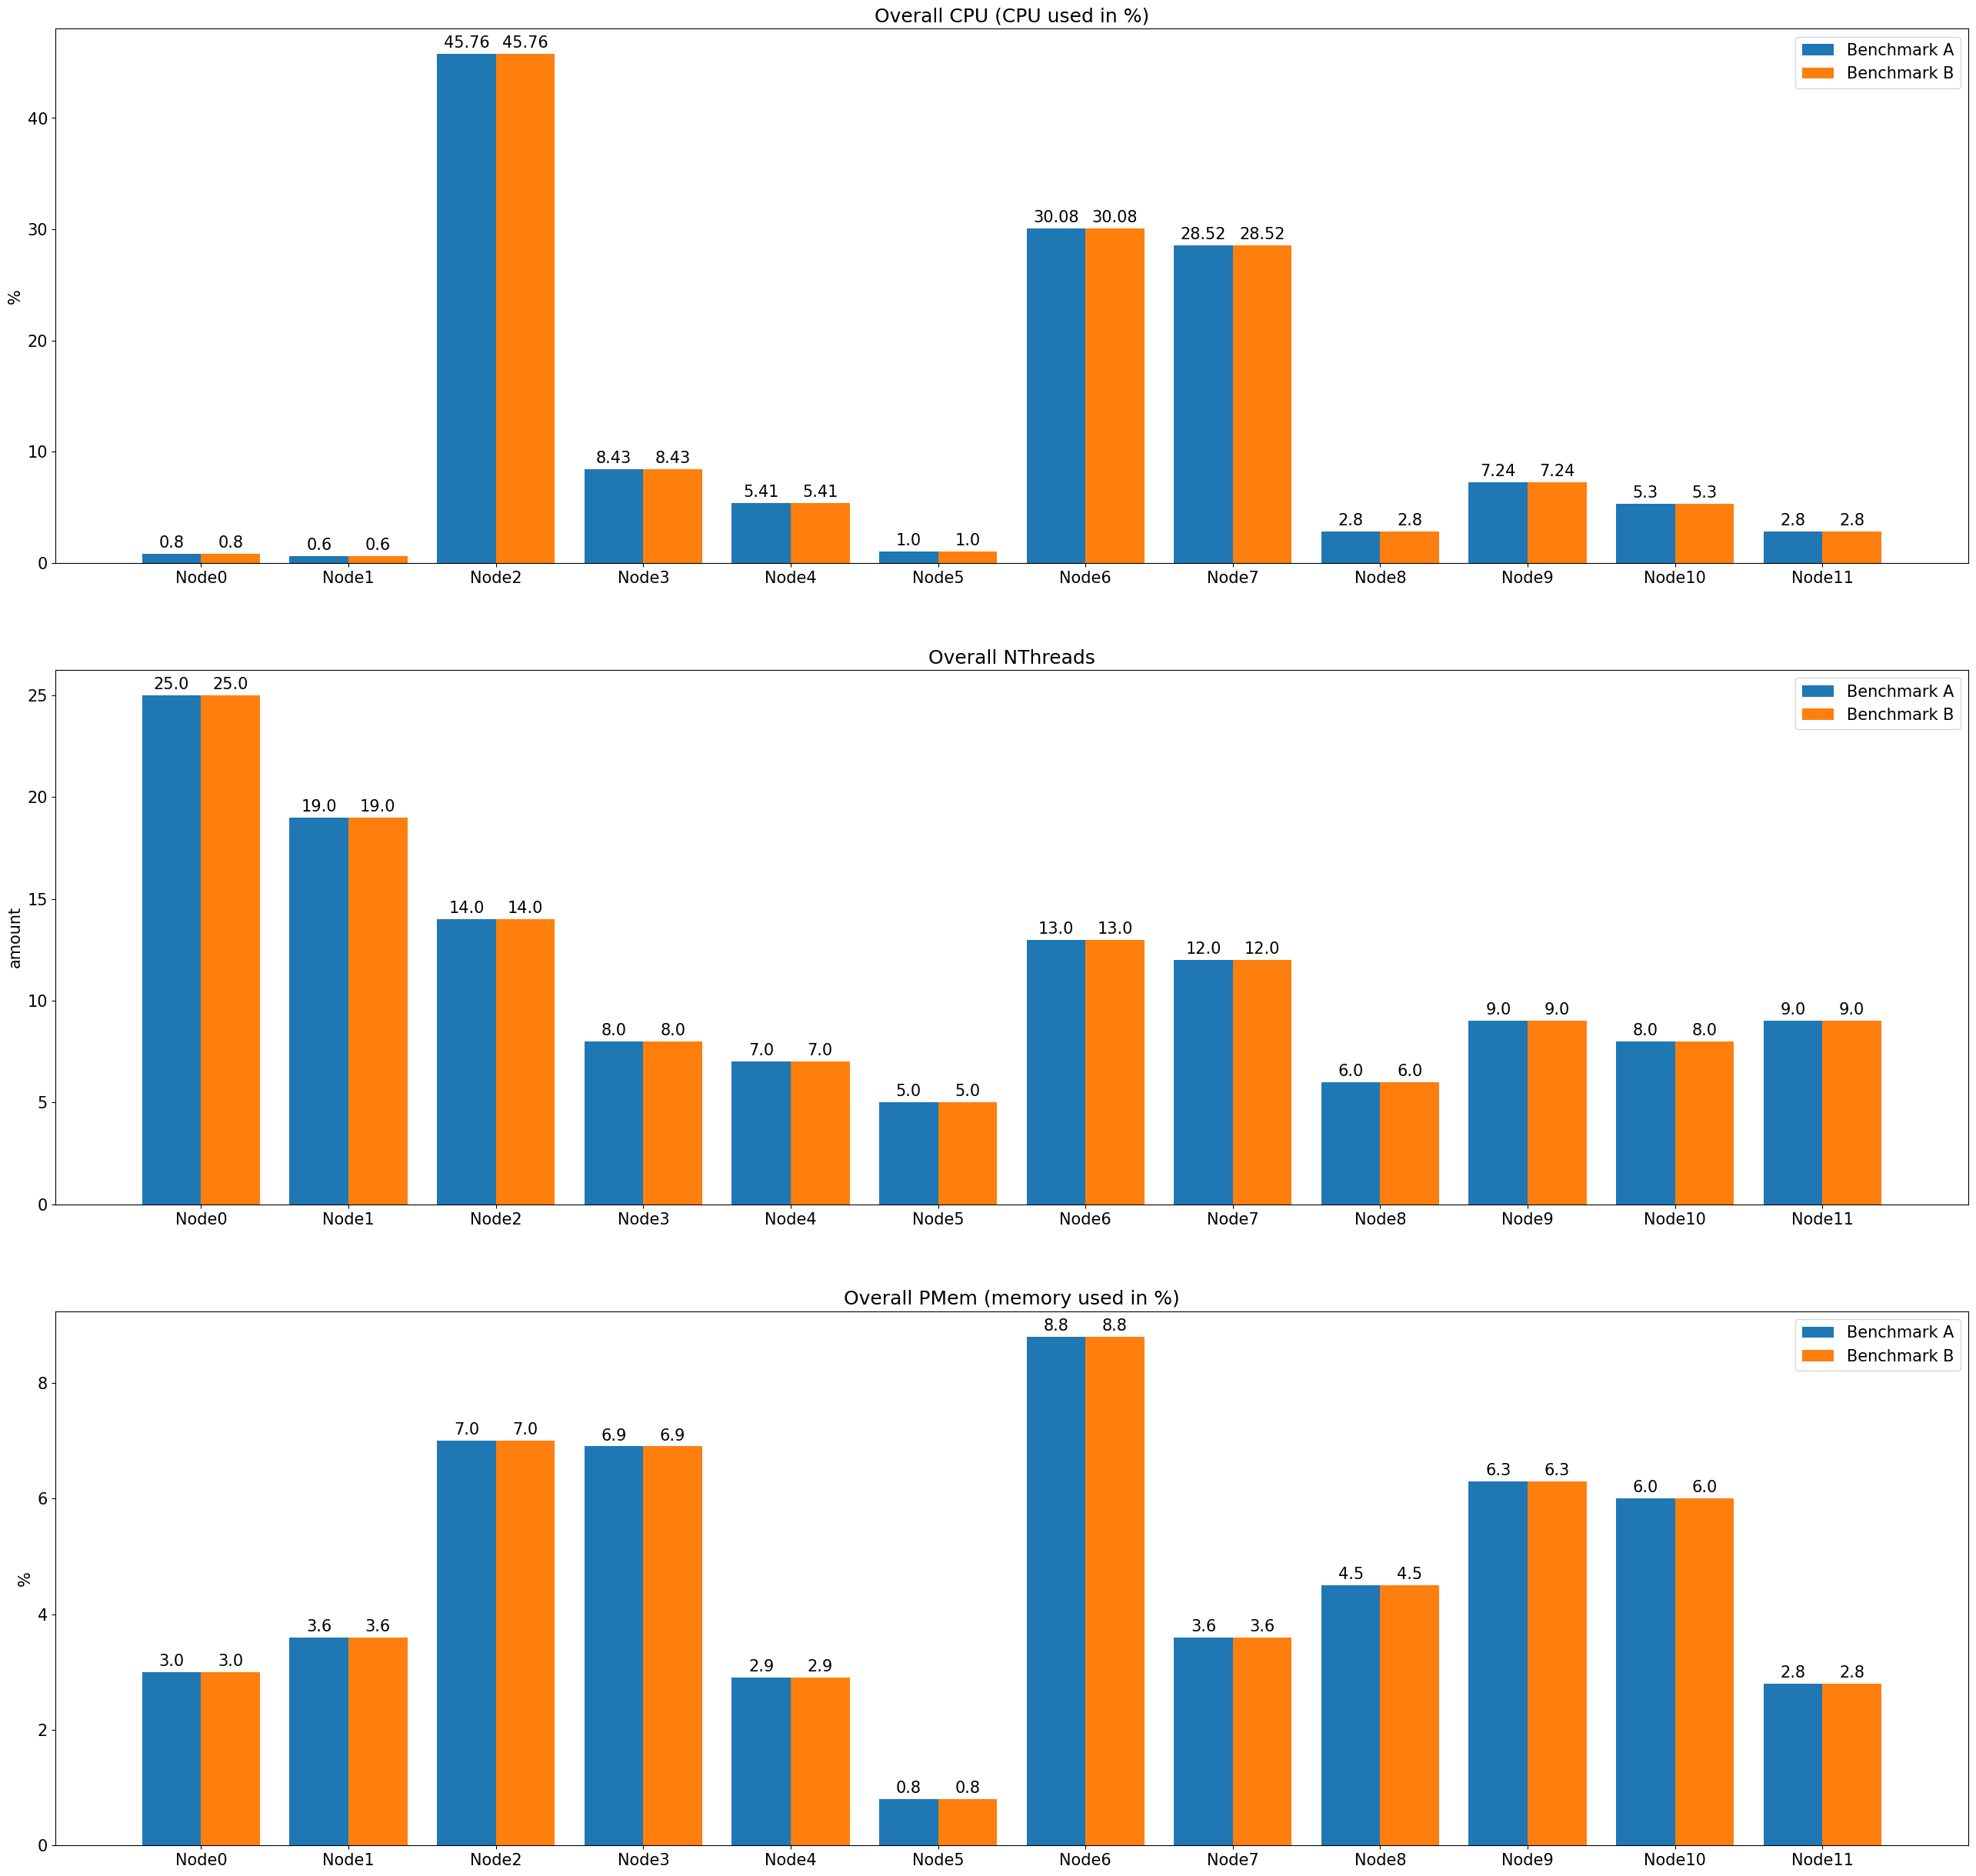

where:
Node 0 = autobot01-fsm_node-1.log
Node 0 = autobot01-logic_gate_node-2.log
Node 0 = autobot01-line_detector_node-3.log
Node 0 = autobot01-ground_projection-4.log
Node 0 = autobot01-duckiebot_visualizer-5.log
Node 0 = autobot01_to_map __log:=/root/.ros/log/1f57bf9e-8b7c-11ea-a58d-b827ebe26535/autobot01_to_map-6.log
Node 0 = autobot01-lane_filter_node-7.log
Node 0 = autobot01-lane_controller_node-8.log
Node 0 = autobot01-lane_pose_visualizer_node-9.log
Node 0 = autobot01-vehicle_detection_node-10.log
Node 0 = autobot01-vehicle_filter_node-11.log
Node 0 = autobot01-vehicle_avoidance_control_node-12.log


In [93]:
if do_comprison:
    dif_nodes = []
    for node, meas in compare_a[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
    ['Overall engineering data node'].items():
        dif_nodes.append(node)
    cpu_a = []
    cpu_b = []
    threads_a = []
    threads_b = []
    mem_a = []
    mem_b = []
    for nod in dif_nodes:
        cpu_a.append(compare_a[0]['Engineering Data']['Performance']['Total engineering data node']\
        ['Measurements']['Overall engineering data node'][nod]['Overall CPU (CPU used in %)']['Mean'])
        cpu_b.append(compare_b[0]['Engineering Data']['Performance']['Total engineering data node']\
        ['Measurements']['Overall engineering data node'][nod]['Overall CPU (CPU used in %)']['Mean'])   
        threads_a.append(compare_a[0]['Engineering Data']['Performance']['Total engineering data node']\
        ['Measurements']['Overall engineering data node'][nod]['Overall NThreads']['Mean'])
        threads_b.append(compare_b[0]['Engineering Data']['Performance']['Total engineering data node']\
        ['Measurements']['Overall engineering data node'][nod]['Overall NThreads']['Mean'])
        mem_a.append(compare_a[0]['Engineering Data']['Performance']['Total engineering data node']\
        ['Measurements']['Overall engineering data node'][nod]['Overall PMem (memory used in %)']['Mean'])
        mem_b.append(compare_b[0]['Engineering Data']['Performance']['Total engineering data node']\
        ['Measurements']['Overall engineering data node'][nod]['Overall PMem (memory used in %)']['Mean'])

    tot_a = [cpu_a,threads_a,mem_a]
    tot_b = [cpu_b,threads_b,mem_b]

    dif_meas = ('Overall CPU (CPU used in %)','Overall NThreads','Overall PMem (memory used in %)')    
    unit = ['%', 'amount', '%']
    labels = []
    for i in range(0,len(dif_nodes)):
        labels.append('Node{0}'.format(i))

    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of the bars

    count = 0
    fig, axes = plt.subplots(nrows=3, ncols=1)
    for i in range(0,len(dif_meas)):
        ax = axes.flatten()[i]
        rects1 = ax.bar(x - width/2, tot_a[i], width, label='Benchmark A')
        rects2 = ax.bar(x + width/2, tot_b[i], width, label='Benchmark B')
        autolabel(rects1)
        autolabel(rects2)
        ax.set_ylabel(unit[i])
        ax.set_title(dif_meas[i])
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

    fig.tight_layout()

    fig.set_figheight(30)
    fig.set_figwidth(30)

    plt.subplots_adjust(wspace=0, hspace=0.2)
    plt.show()


    print("where:")
    for nod in dif_nodes:
        print('Node 0 = '+nod)

else:
    dif_nodes = []
    for node, meas in compare_a[0]['Engineering Data']['Performance']['Total engineering data node']['Measurements']\
    ['Overall engineering data node'].items():
        dif_nodes.append(node)
    cpu_a = []
    threads_a = []
    mem_a = []
    for nod in dif_nodes:
        cpu_a.append(compare_a[0]['Engineering Data']['Performance']['Total engineering data node']\
        ['Measurements']['Overall engineering data node'][nod]['Overall CPU (CPU used in %)']['Mean'])
        threads_a.append(compare_a[0]['Engineering Data']['Performance']['Total engineering data node']\
        ['Measurements']['Overall engineering data node'][nod]['Overall NThreads']['Mean'])
        mem_a.append(compare_a[0]['Engineering Data']['Performance']['Total engineering data node']\
        ['Measurements']['Overall engineering data node'][nod]['Overall PMem (memory used in %)']['Mean'])

    tot_a = [cpu_a,threads_a,mem_a]

    dif_meas = ('Overall CPU (CPU used in %)','Overall NThreads','Overall PMem (memory used in %)')    
    unit = ['%', 'amount', '%']
    labels = []
    for i in range(0,len(dif_nodes)):
        labels.append('Node{0}'.format(i))

    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of the bars

    count = 0
    fig, axes = plt.subplots(nrows=3, ncols=1)
    for i in range(0,len(dif_meas)):
        ax = axes.flatten()[i]
        rects1 = ax.bar(x, tot_a[i], width, label='Your Benchmark')
        autolabel(rects1)
        ax.set_ylabel(unit[i])
        ax.set_title(dif_meas[i])
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

    fig.tight_layout()

    fig.set_figheight(30)
    fig.set_figwidth(30)

    plt.subplots_adjust(wspace=0, hspace=0.2)
    plt.show()


    print("where:")
    for nod in dif_nodes:
        print('Node 0 = '+nod)
    

Below you see a comparison between the update frequency, the messages counted as well as the number of connections of the nodes that were recorded on the Duckiebots.

For the Benchmark A there was 2 times a bag directly on the Duckiebot recorded whilst running    the experiments compared to Benchmark B where 2 bags recorded over the entire Benchmark.
In the bags recorded on the Duckiebot during the Benchmark A, there were 3 nodes recorded,    whilst during the Benchmark B 3 nodes were recorded


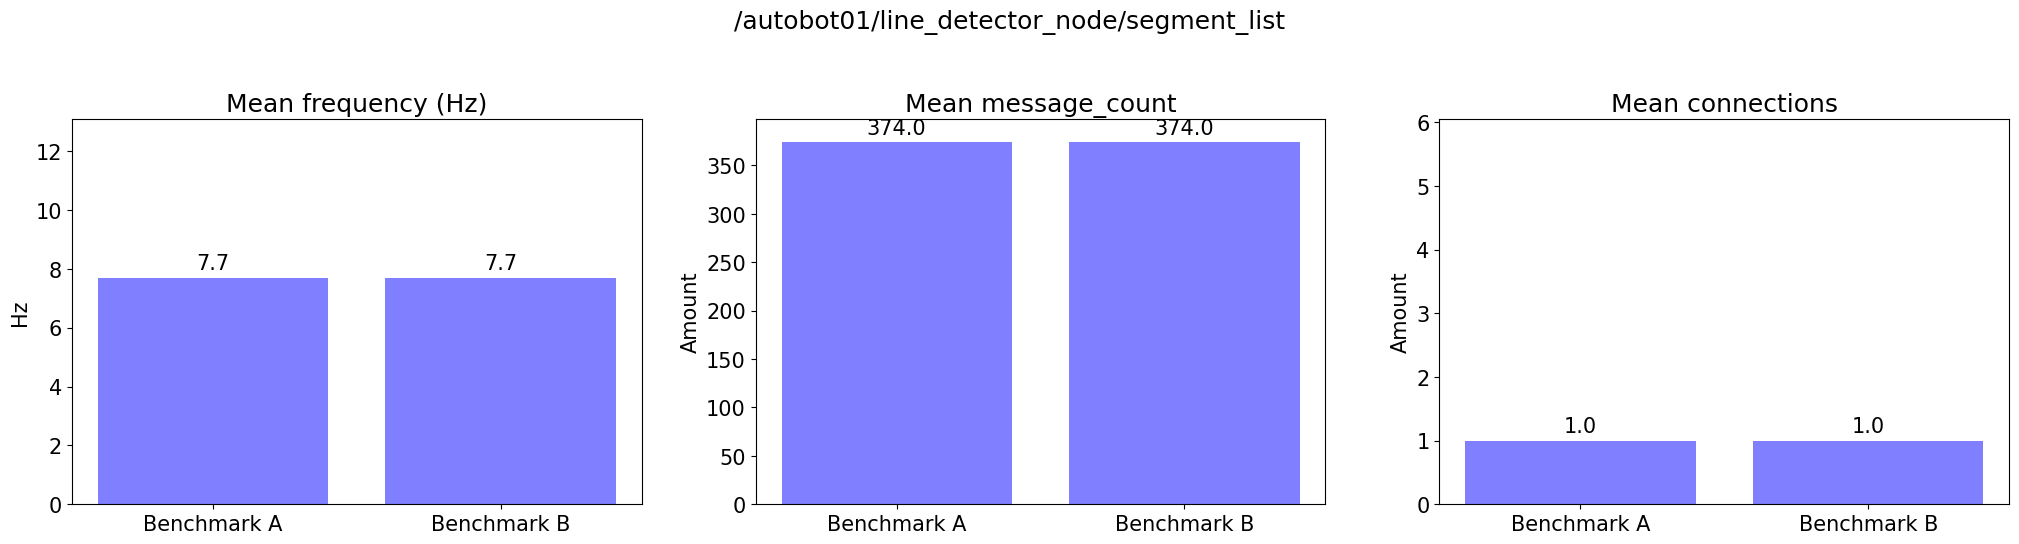

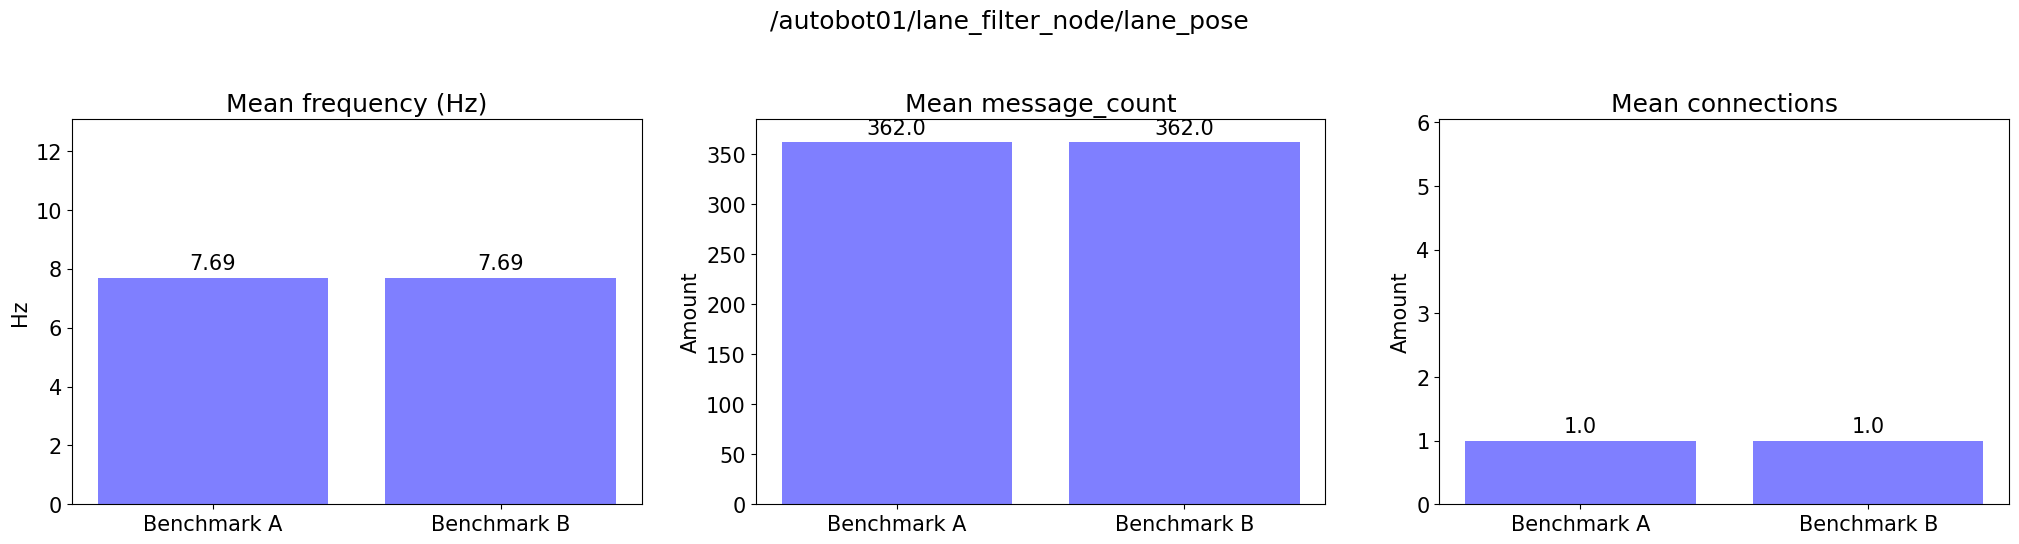

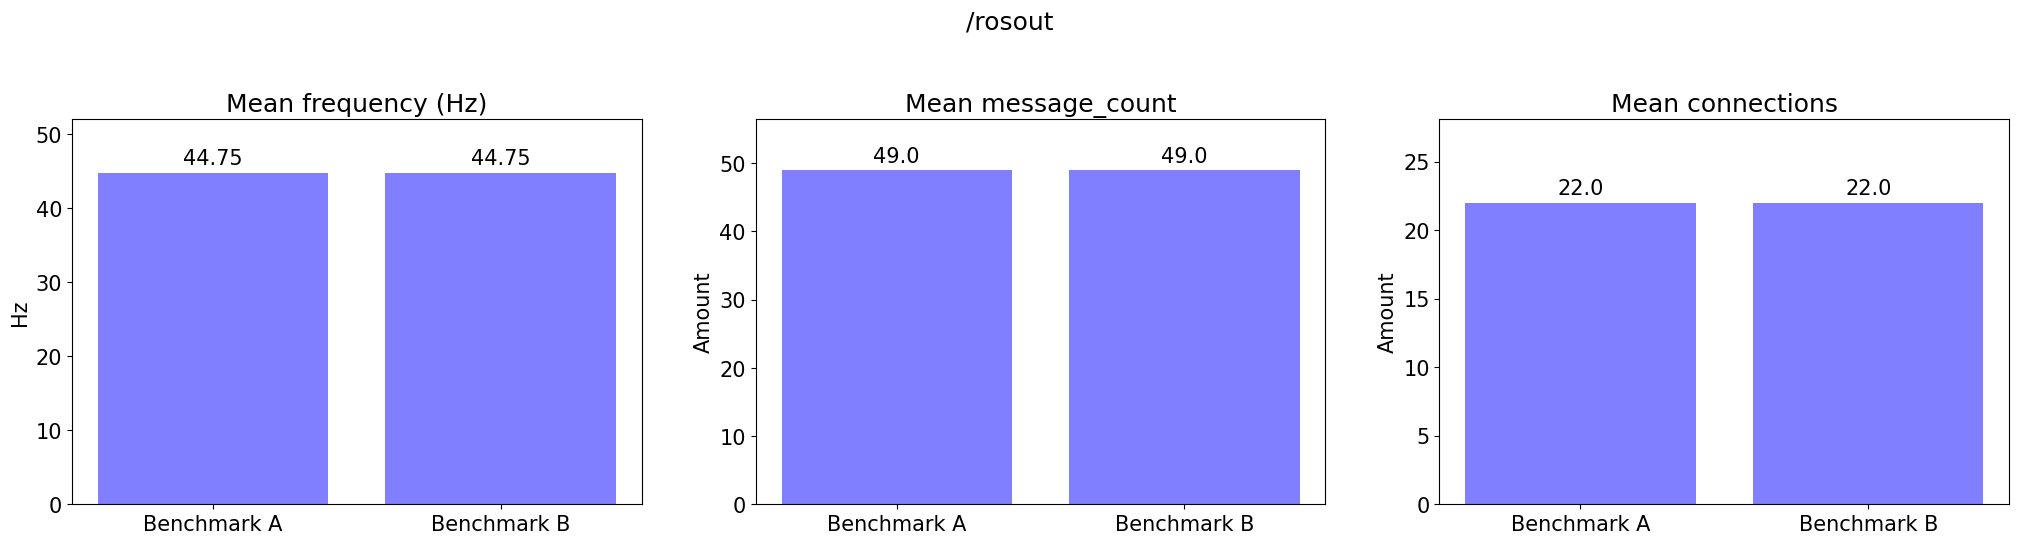

In [108]:
if do_comparison and comp_db_dat:
    nb_of_files_a = compare_a[0]['Engineering Data']['Performance']['Node Info']['Nb of files']
    nb_of_nodes_a = compare_a[0]['Engineering Data']['Performance']['Node Info']['Nb of nodes']
    nb_of_files_b = compare_b[0]['Engineering Data']['Performance']['Node Info']['Nb of files']
    nb_of_nodes_b = compare_b[0]['Engineering Data']['Performance']['Node Info']['Nb of nodes']
    
    print("For the Benchmark A there was {0} times a bag directly on the Duckiebot recorded whilst running\
    the experiments compared to Benchmark B where {1} bags recorded over the entire Benchmark.".format(nb_of_files_a,nb_of_files_b))
    
    print("In the bags recorded on the Duckiebot during the Benchmark A, there were {0} nodes recorded,\
    whilst during the Benchmark B {1} nodes were recorded".format(nb_of_nodes_a,nb_of_nodes_b))
    
    for nod,inf in compare_a[0]['Engineering Data']['Performance']['Node Info']['Measurements'].items():
        width = 0.35
        plt.rcParams.update({'font.size': 15})
        fig, axes = plt.subplots(nrows=1, ncols=3)
        fig.subplots_adjust(hspace=0.5)
        fig.suptitle(nod, y=1.1)
        objects = ('Benchmark A', 'Benchmark B')
        x_pos = np.arange(len(objects))
        count = 0
        
        measurements = ('Mean frequency (Hz)','Mean message_count','Mean connections')
        
        for mes in measurements:
            performance = [inf[mes],\
                           compare_b[0]['Engineering Data']['Performance']['Node Info']['Measurements'][nod][mes]]
            
            if performance[0] > performance[1]:
                advantages.update({nod: 'A'})
                winner_color = ['green', 'red']
            elif performance[0] < performance[1]:
                advantages.update({nod: 'B'})
                winner_color = ['red', 'green']
            elif performance[0] == performance[1]:
                advantages.update({nod: 'equal'})
                winner_color = ['blue', 'blue']   
            else:
                winner_color = ['black', 'black']
                           
            ax = axes.flatten()[count]
            rec = ax.bar(x_pos, performance, align='center', alpha=0.5, color=winner_color)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(objects)
            if mes == 'Mean frequency (Hz)':
                ax.set_ylabel('Hz')
            else:
                ax.set_ylabel('Amount')
            ax.set_title(mes)
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom, top+5) 
            autolabel(rec)


            count+=1
        
        
        fig.set_figheight(5)
        fig.set_figwidth(25)
elif not do_comparison:
    width= 0.35
    nb_of_files_a = compare_a[0]['Engineering Data']['Performance']['Node Info']['Nb of files']
    nb_of_nodes_a = compare_a[0]['Engineering Data']['Performance']['Node Info']['Nb of nodes']
    
    for nod,inf in compare_a[0]['Engineering Data']['Performance']['Node Info']['Measurements'].items():
        plt.rcParams.update({'font.size': 15})
        fig, axes = plt.subplots(nrows=1, ncols=3)
        fig.subplots_adjust(hspace=0.5)
        fig.suptitle(nod, y=1.1)
        objects = ('Benchmark A')
        x_pos = np.arange(1)
        count = 0
        
        measurements = ('Mean frequency (Hz)','Mean message_count','Mean connections')
        
        for mes in measurements:
                           
            ax = axes.flatten()[count]
            rec = ax.bar(x_pos, inf[mes],width, align='center', alpha=0.5, color=winner_color)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(objects)
            if mes == 'Mean frequency (Hz)':
                ax.set_ylabel('Hz')
            else:
                ax.set_ylabel('Amount')
            ax.set_title(mes)
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom, top+5) 
            autolabel(rec)


            count+=1
        
        
        fig.set_figheight(5)
        fig.set_figwidth(25)
        
else:
    print("unfortunately this comparison can not be made as one of the Benchmakrks does not have this information")

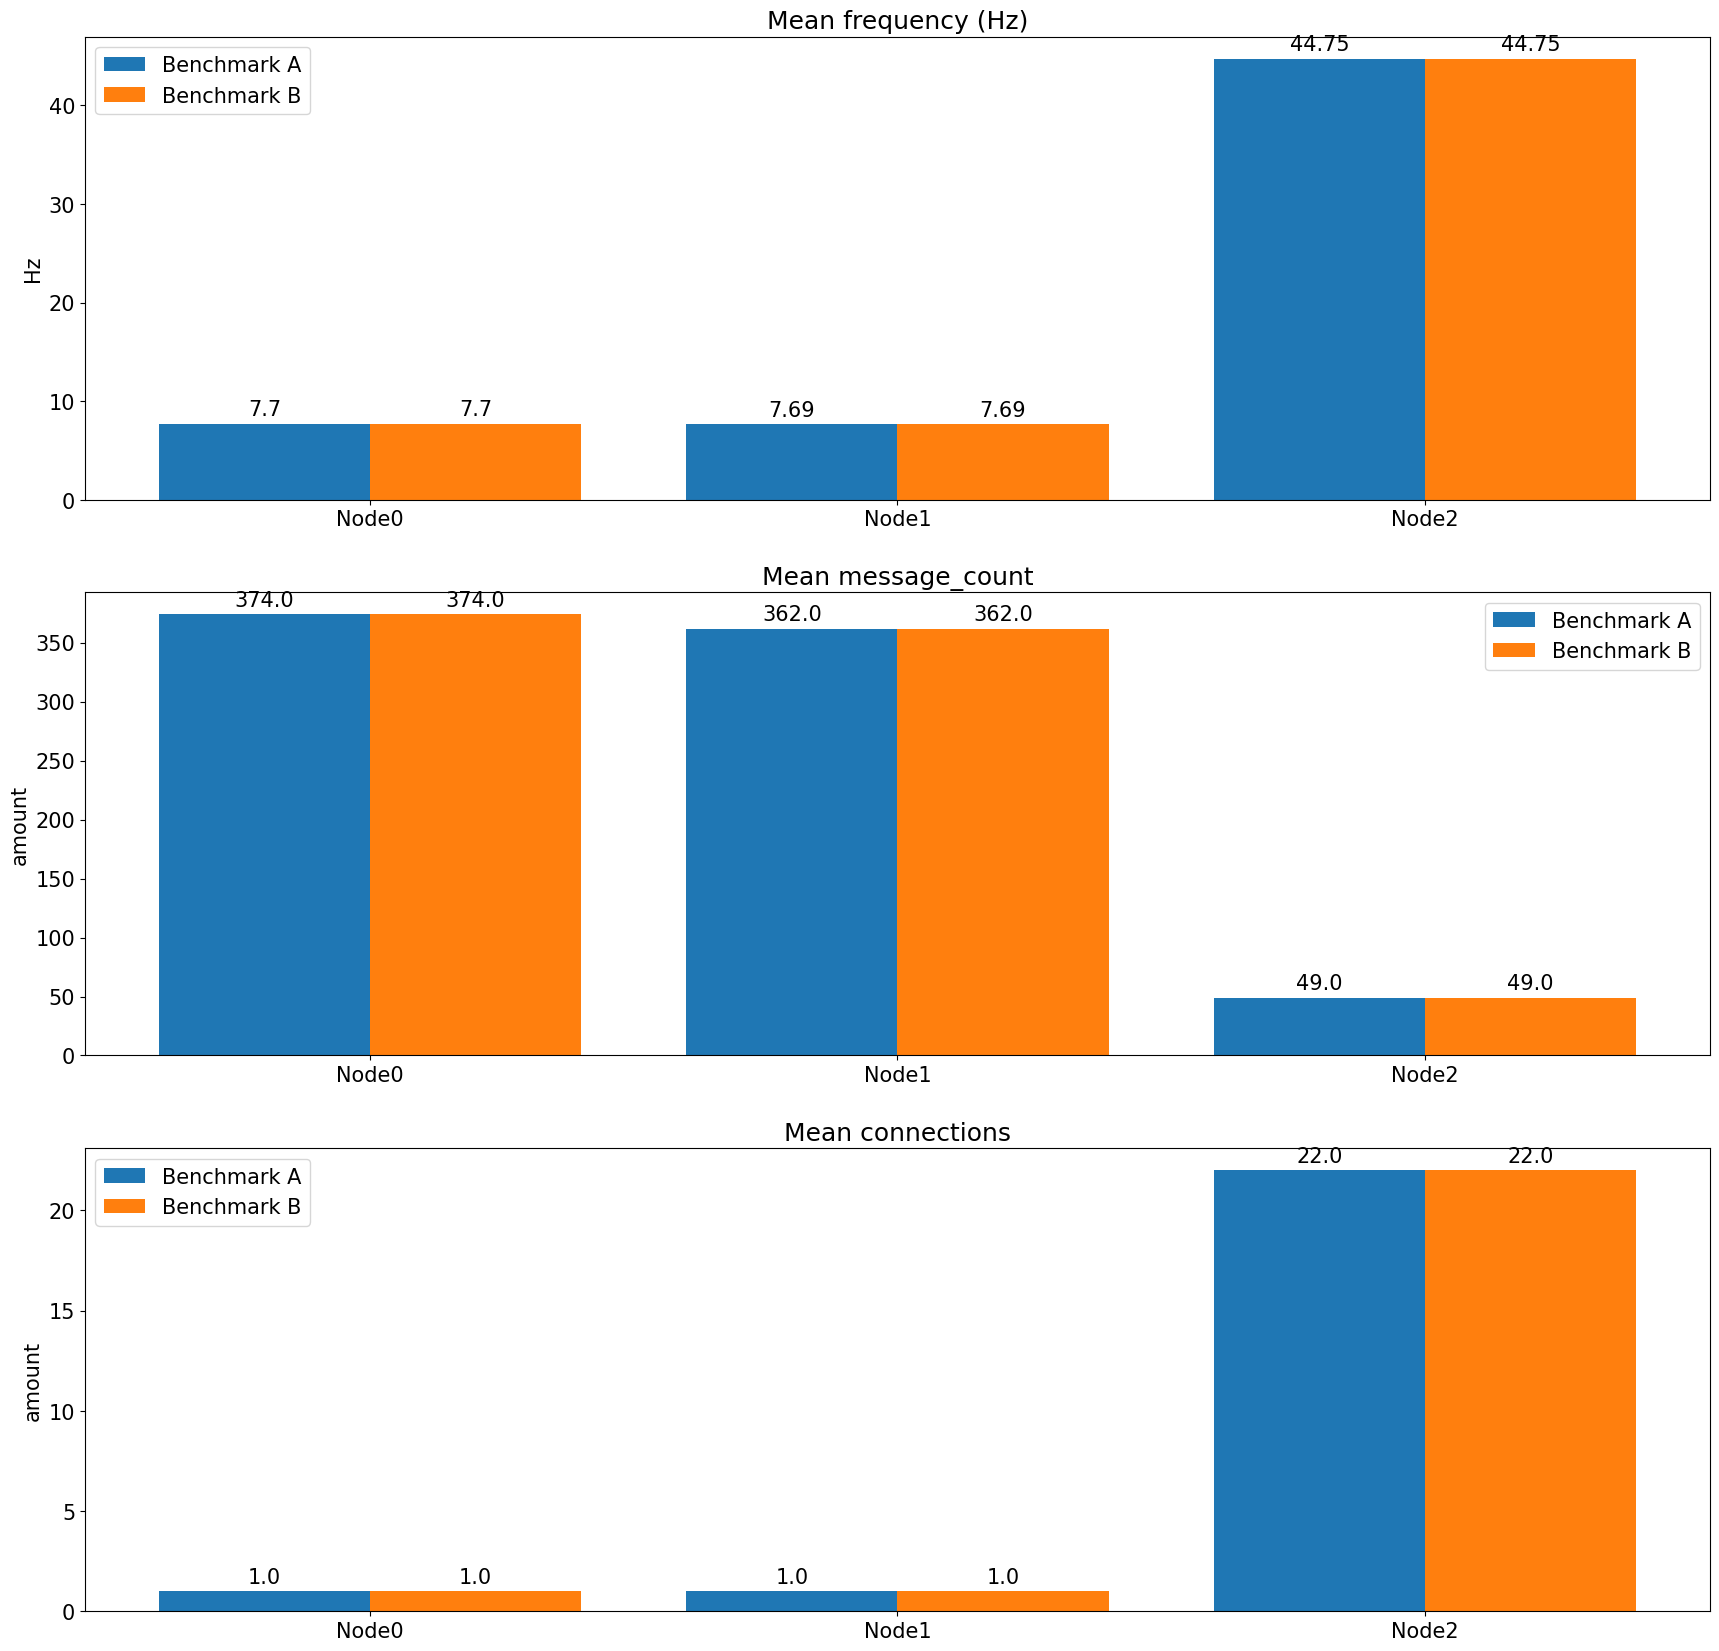

where:
Node 0 = /autobot01/line_detector_node/segment_list
Node 0 = /autobot01/lane_filter_node/lane_pose
Node 0 = /rosout


In [109]:
if do_comprison:
    dif_nodes = []
    for node, meas in  compare_a[0]['Engineering Data']['Performance']['Node Info']['Measurements'].items():
        dif_nodes.append(node)
    mean_freq_a = []
    mean_freq_b = []
    mean_mes_cnt_a = []
    mean_mes_cnt_b = []
    mean_con_a = []
    mean_con_b = []
    
    measurements = ('Mean frequency (Hz)','Mean message_count','Mean connections')
    unit = ['Hz', 'amount', 'amount']

    
    for nod in dif_nodes:
        mean_freq_a.append(compare_a[0]['Engineering Data']['Performance']['Node Info']['Measurements'][nod]['Mean frequency (Hz)'])
        mean_freq_b.append(compare_b[0]['Engineering Data']['Performance']['Node Info']['Measurements'][nod]['Mean frequency (Hz)'])   
        mean_mes_cnt_a.append(compare_a[0]['Engineering Data']['Performance']['Node Info']['Measurements'][nod]['Mean message_count'])
        mean_mes_cnt_b.append(compare_b[0]['Engineering Data']['Performance']['Node Info']['Measurements'][nod]['Mean message_count'])
        mean_con_a.append(compare_a[0]['Engineering Data']['Performance']['Node Info']['Measurements'][nod]['Mean connections'])
        mean_con_b.append(compare_b[0]['Engineering Data']['Performance']['Node Info']['Measurements'][nod]['Mean connections'])

    tot_a = [mean_freq_a,mean_mes_cnt_a,mean_con_a]
    tot_b = [mean_freq_b,mean_mes_cnt_b,mean_con_b]

    labels = []
    for i in range(0,len(dif_nodes)):
        labels.append('Node{0}'.format(i))

    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of the bars

    count = 0
    fig, axes = plt.subplots(nrows=3, ncols=1)
    for i in range(0,len(measurements)):
        ax = axes.flatten()[i]
        rects1 = ax.bar(x - width/2, tot_a[i], width, label='Benchmark A')
        rects2 = ax.bar(x + width/2, tot_b[i], width, label='Benchmark B')
        autolabel(rects1)
        autolabel(rects2)
        ax.set_ylabel(unit[i])
        ax.set_title(measurements[i])
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

    fig.tight_layout()

    fig.set_figheight(20)
    fig.set_figwidth(20)

    plt.subplots_adjust(wspace=0, hspace=0.2)
    plt.show()


    print("where:")
    for nod in dif_nodes:
        print('Node 0 = '+nod)

else:
    dif_nodes = []
    for node, meas in  compare_a[0]['Engineering Data']['Performance']['Node Info']['Measurements'].items():
        dif_nodes.append(node)
    mean_freq_a = []
    mean_mes_cnt_a = []
    mean_con_a = []
    
    measurements = ('Mean frequency (Hz)','Mean message_count','Mean connections')
    unit = ['Hz', 'amount', 'amount']

    
    for nod in dif_nodes:
        mean_freq_a.append(compare_a[0]['Engineering Data']['Performance']['Node Info']['Measurements'][nod]['Mean frequency (Hz)'])
        mean_mes_cnt_a.append(compare_a[0]['Engineering Data']['Performance']['Node Info']['Measurements'][nod]['Mean message_count'])
        mean_con_a.append(compare_a[0]['Engineering Data']['Performance']['Node Info']['Measurements'][nod]['Mean connections'])
        
    tot_a = [mean_freq_a,mean_mes_cnt_a,mean_con_a]
    
    labels = []
    for i in range(0,len(dif_nodes)):
        labels.append('Node{0}'.format(i))

    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of the bars

    count = 0
    fig, axes = plt.subplots(nrows=3, ncols=1)
    for i in range(0,len(measurements)):
        ax = axes.flatten()[i]
        rects1 = ax.bar(x - width/2, tot_a[i], width, label='Your Benchmark')
        autolabel(rects1)
        ax.set_ylabel(unit[i])
        ax.set_title(measurements[i])
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

    fig.tight_layout()

    fig.set_figheight(20)
    fig.set_figwidth(20)

    plt.subplots_adjust(wspace=0, hspace=0.2)
    plt.show()


    print("where:")
    for nod in dif_nodes:
        print('Node 0 = '+nod)

Latency:
In the bags recorded on the Duckiebot during the Benchmark A, the latency was measured 3 times  ,            whilst during the Benchmark B the latency was measured 3 times.

The standard deviation of the latency measurde in the Benchmark A is 0.0 ms, this leads to a coefficient of variation of 0.0 ms.
 The minimal latency ever measured was 339.4 ms where as the maximal latency was 339.4 ms

The standard deviation of the latency measurde in the Benchmark B is 0.0 ms, this leads to a coefficient of variation of 0.0 ms.
 The minimal latency ever measured was 339.4 ms where as the maximal latency was 339.4 ms



Latency[ms]	Benchmark A	Benchmark B	difference	B relative to A		Winner
-----------------------------------------------------------------------------------------------
Mean:		 339.4 		 339.4 		 0.0 		 100.0 			 equal
Std:		 0.0 		 0.0 		 0.0 		 100.0 			 equal
Min:		 339.4 		 339.4 		 0.0 		 100.0 			 equal
Max:		 339.4 		 339.4 		 0.0 		 100.0 			 equal




Segments counte

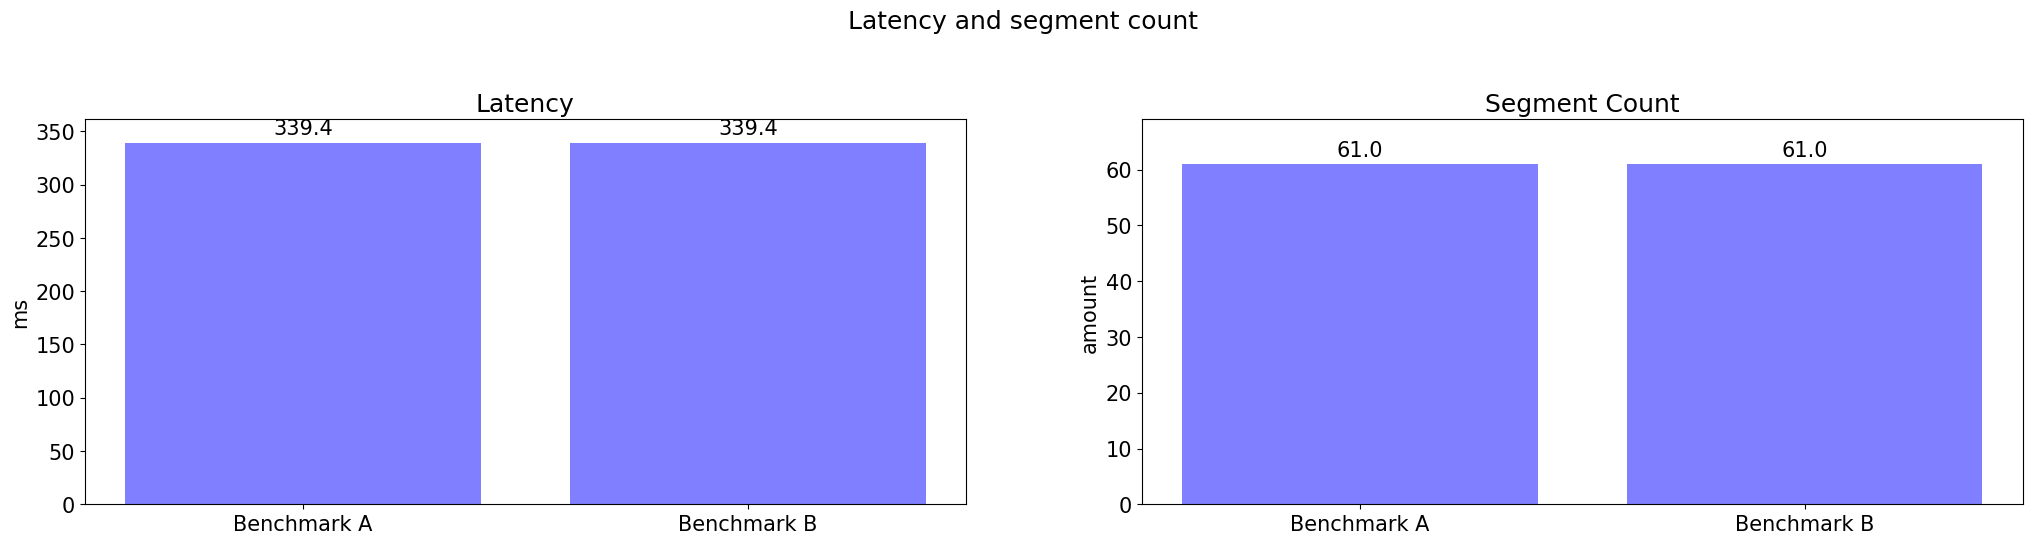

In [110]:
if do_comparison and comp_db_dat:
    nb_of_lat_a = compare_a[0]['Engineering Data']['Performance']['Latency']['Nb of latency meas. per file']
    nb_of_lat_b = compare_b[0]['Engineering Data']['Performance']['Latency']['Nb of latency meas. per file']
    nb_of_seg_cnt_a = compare_a[0]['Engineering Data']['Performance']['Segment Count']['Nb of segment count meas. per file']
    nb_of_seg_cnt_b = compare_b[0]['Engineering Data']['Performance']['Segment Count']['Nb of segment count meas. per file']
    
    
    plt.rcParams.update({'font.size': 15})
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle('Latency and segment count', y=1.1)
    objects = ('Benchmark A', 'Benchmark B')
    x_pos = np.arange(len(objects))
    count = 0

    measurements = ('Latency','Segment Count')
    for prop in measurements:
        if prop == 'Latency':
            print("Latency:")
            print("In the bags recorded on the Duckiebot during the Benchmark A, the latency was measured {0} times  ,\
            whilst during the Benchmark B the latency was measured {1} times.\n".format(nb_of_lat_a,nb_of_lat_b))
            performance = [compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall mean latency (ms)'],\
                           compare_b[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall mean latency (ms)']]
            if performance[0] < performance[1]:
                advantages.update({prop: 'A'})
                winner_color = ['green', 'red']
            elif performance[0] > performance[1]:
                advantages.update({prop: 'B'})
                winner_color = ['red', 'green']
            elif performance[0] == performance[1]:
                advantages.update({prop: 'equal'})
                winner_color = ['blue', 'blue']   
            else:
                winner_color = ['black', 'black']
            
            std_a = compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall std latency (ms)']
            std_b = compare_b[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall std latency (ms)']
            cv_a = compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall CV latency']
            cv_b = compare_b[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall CV latency']
            min_a = compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall min latency (ms)']
            max_a = compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall max latency(ms)']
            min_b = compare_b[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall min latency (ms)']
            max_b = compare_b[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall max latency(ms)']
            
            txt_a = "The standard deviation of the latency measurde in the Benchmark A is {0} ms, this leads to a coefficient of variation of {1} ms.\n The minimal latency ever measured was {2} ms where as the maximal latency was {3} ms".format(std_a,cv_a,min_a,max_a)
            txt_b = "The standard deviation of the latency measurde in the Benchmark B is {0} ms, this leads to a coefficient of variation of {1} ms.\n The minimal latency ever measured was {2} ms where as the maximal latency was {3} ms".format(std_b,cv_b,min_b,max_b)
            
            
            
            
            ax = axes.flatten()[count]
            rec = ax.bar(x_pos, performance, align='center', alpha=0.5, color=winner_color)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(objects)
            if prop == 'Latency':
                ax.set_ylabel('ms')
            else:
                ax.set_ylabel('amount')
            ax.set_title(prop)
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom, top+5) 
            autolabel(rec)


            count+=1


            fig.set_figheight(5)
            fig.set_figwidth(25)
            
            print(txt_a+'\n')
            print(txt_b+'\n')
            print('\n')
            
            
            print('Latency[ms]\tBenchmark A\tBenchmark B\tdifference\tB relative to A\t\tWinner')
            print('-----------------------------------------------------------------------------------------------')
            win,brela,diff,sign = comp_low_bet(performance[0],performance[1])
            print('Mean' + ':\t\t', performance[0], '\t\t', performance[1], '\t\t',diff, '\t\t',brela,'\t\t\t',win)
            win,brela,diff,sign = comp_low_bet(std_a,std_b)
            print('Std' + ':\t\t', float(np.round(std_a,1)), '\t\t', float(np.round(std_b,1)), '\t\t',diff, '\t\t',brela,'\t\t\t',win)
            win,brela,diff,sign = comp_low_bet(min_a,min_b)
            print('Min' + ':\t\t', min_a, '\t\t', min_b, '\t\t',diff, '\t\t',brela,'\t\t\t',win)
            win,brela,diff,sign = comp_low_bet(max_a,max_b)
            print('Max' + ':\t\t', max_a, '\t\t', max_b, '\t\t',diff, '\t\t',brela,'\t\t\t',win)

            
            
            
        else:
            print('\n')
            print('\n')
            print("Segments counted:")
            print("In the bags recorded on the Duckiebot during the Benchmark A, there was {0} times a segment count measured, whilst during the Benchmark B the segment count was measured {1} times".format(nb_of_seg_cnt_a,nb_of_seg_cnt_b))
            performance = [compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall mean segment count'],\
                           compare_b[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall mean segment count']]
        
            if performance[0] > performance[1]:
                advantages.update({prop: 'A'})
                winner_color = ['green', 'red']
            elif performance[0] < performance[1]:
                advantages.update({prop: 'B'})
                winner_color = ['red', 'green']
            elif performance[0] == performance[1]:
                advantages.update({prop: 'equal'})
                winner_color = ['blue', 'blue']   
            else:
                winner_color = ['black', 'black']
                
            std_a = compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall std segment count']
            std_b = compare_b[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall std segment count']
            cv_a = compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall CV segment count']
            cv_b = compare_b[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall CV segment count']
            min_a = compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall min segment count']
            max_a = compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall max segment count']
            min_b = compare_b[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall min segment count']
            max_b = compare_b[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall max segment count']
            
            txt_a = "The standard deviation of the segments counted in the Benchmark A is {0}, this leads to a coefficient of variation of {1}.\n The minimal number of counted ever counted was {2} where as the maximal number counted was {3}".format(std_a,cv_a,min_a,max_a)
            txt_b = "The standard deviation of the segments counted in the Benchmark B is {0}, this leads to a coefficient of variation of {1}.\n The minimal number of counted ever counted was {2} where as the maximal number counted was {3}".format(std_b,cv_b,min_b,max_b)
            

            ax = axes.flatten()[count]
            rec = ax.bar(x_pos, performance, align='center', alpha=0.5, color=winner_color)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(objects)
            if prop == 'Latency':
                ax.set_ylabel('ms')
            else:
                ax.set_ylabel('amount')
            ax.set_title(prop)
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom, top+5) 
            autolabel(rec)
            
            count+=1


            fig.set_figheight(5)
            fig.set_figwidth(25)
            
            print('\n')
            print(txt_a+'\n')
            print(txt_b+'\n')
            print('\n')
            
            
            print('Segments Counted\tBenchmark A\tBenchmark B\tdifference\tB relative to A\t\tWinner')
            print('-----------------------------------------------------------------------------------------------')
            win,brela,diff,sign = comp_high_bet(performance[0],performance[1])
            print('Mean' + ':\t\t\t', performance[0], '\t\t', performance[1], '\t\t',diff, '\t\t',brela,'\t\t\t',win)
            win,brela,diff,sign = comp_low_bet(std_a,std_b)
            print('Std' + ':\t\t\t', float(np.round(std_a,1)), '\t\t', float(np.round(std_b,1)), '\t\t',diff, '\t\t',brela,'\t\t\t',win)
            win,brela,diff,sign = comp_high_bet(min_a,min_b)
            print('Min' + ':\t\t\t', min_a, '\t\t', min_b, '\t\t',diff, '\t\t',brela,'\t\t\t',win)
            win,brela,diff,sign = comp_high_bet(max_a,max_b)
            print('Max' + ':\t\t\t', max_a, '\t\t', max_b, '\t\t',diff, '\t\t',brela,'\t\t\t',win)
            
            print('\n')
            print('\n')
            


elif not do_comparison:
    nb_of_lat_a = compare_a[0]['Engineering Data']['Performance']['Latency']['Nb of latency meas. per file']
    nb_of_seg_cnt_a = compare_a[0]['Engineering Data']['Performance']['Segment Count']['Nb of segment count meas. per file']
    
    plt.rcParams.update({'font.size': 15})
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle('Latency and segment count', y=1.1)
    objects = ('Benchmark A')
    x_pos = np.arange(1)
    count = 0
    width = 0.35
    measurements = ('Latency','Segment Count')
    for prop in measurements:
        if prop == 'Latency':
            print("Latency:")
            print("In the bags recorded on the Duckiebot during your Benchmark, the latency was measured {0} times.\n".format(nb_of_lat_a))
            mean_a = compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall mean latency (ms)']
           
            
            std_a = compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall std latency (ms)']
            cv_a = compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall CV latency']
            min_a = compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall min latency (ms)']
            max_a = compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall max latency(ms)']
            
            txt_a = "The standard deviation of the latency measurde in your Benchmark is {0} ms, this leads to a coefficient of variation of {1} ms.\n The minimal latency ever measured was {2} ms where as the maximal latency was {3} ms".format(std_a,cv_a,min_a,max_a)
            
            ax = axes.flatten()[count]
            rec = ax.bar(x_pos, mean_a,width, align='center', alpha=0.5, color=winner_color)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(objects)
            if prop == 'Latency':
                ax.set_ylabel('ms')
            else:
                ax.set_ylabel('amount')
            ax.set_title(prop)
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom, top+5) 
            autolabel(rec)


            count+=1


            fig.set_figheight(5)
            fig.set_figwidth(25)
            
            print(txt_a+'\n')
            
            
            print('Latency[ms]\tYour Benchmark')
            print('-----------------------------------------------------------------------------------------------')
            print('Mean' + ':\t\t', mean_a)
            print('Std' + ':\t\t', float(np.round(std_a,1)))
            print('Min' + ':\t\t', min_a)
            print('Max' + ':\t\t', max_a)

            
            
            
        else:
            print('\n')
            print('\n')
            print("Segments counted:")
            print("In the bags recorded on the Duckiebot during your Benchmark, there was {0} times a segment count measured.".format(nb_of_seg_cnt_a))
            mean_a = compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall mean segment count']
                           
            std_a = compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall std segment count']
            cv_a = compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall CV segment count']
            min_a = compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall min segment count']
            max_a = compare_a[0]['Engineering Data']['Performance'][prop]['Measurements']['Overall max segment count']
            
            txt_a = "The standard deviation of the segments counted in your Benchmark is {0}, this leads to a coefficient of variation of {1}.\n The minimal number of counted ever counted was {2} where as the maximal number counted was {3}".format(std_a,cv_a,min_a,max_a)
            
            ax = axes.flatten()[count]
            rec = ax.bar(x_pos, performance, align='center', alpha=0.5, color=winner_color)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(objects)
            if prop == 'Latency':
                ax.set_ylabel('ms')
            else:
                ax.set_ylabel('amount')
            ax.set_title(prop)
            bottom, top = ax.get_ylim()
            ax.set_ylim(bottom, top+5) 
            autolabel(rec)
            
            count+=1


            fig.set_figheight(5)
            fig.set_figwidth(25)
            print(txt_a+'\n')
            print('\n')
            
            
            print('Segments Counted\tYour Benchmark')
            print('-----------------------------------------------------------------------------------------------')
            print('Mean' + ':\t\t\t', mean_a)
            print('Std' + ':\t\t\t', float(np.round(std_a,1)))
            print('Min' + ':\t\t\t', min_a)
            print('Max' + ':\t\t\t', max_a)
            
            print('\n')
            print('\n')
        
else:
    print("unfortunately this comparison can not be made as one of the Benchmakrks does not have this information")

Now lets have a look at the fun part, the actual performance of the Benchmarks.
First we plot the mean trajectory of all experiments ran for the two Benchmarks that the Duckiebot was driving. As well as all the different trajectories in differen colors. This will help you already from the eye to see the difference in performance
ToDO

Then we look at the number of times the Duckiebot crashed, etc
ToDo

In [111]:
all_trajectories_a = [] 
all_trajectories_b = [] 


all_cur_traj = []
for j,traj in enumerate(compare_a[0]['Results']['all_trajectories']['All results']):
    for i in range(0, len(compare_a[0]['Results']['all_trajectories']['All results'][j])):
        cur_traj = np.array(compare_a[0]['Results']['all_trajectories']['All results'][j][i])
        all_cur_traj.append(cur_traj)
    all_trajectories_a.append(all_cur_traj)
    
all_cur_traj = []
for j,traj in enumerate(compare_b[0]['Results']['all_trajectories']['All results']):
    for i in range(0, len(compare_b[0]['Results']['all_trajectories']['All results'][j])):
        cur_traj = np.array(compare_b[0]['Results']['all_trajectories']['All results'][j][i])
        all_cur_traj.append(cur_traj)
    all_trajectories_b.append(all_cur_traj)    
    


In [112]:
import collections

try:
    del m    
except:
    pass
m = dw.load_map('linus_loop')


used_lane_segments_list_a, lane_segments_SE2_a = get_used_lanes(all_trajectories_a)
used_lane_segments_list_b, lane_segments_SE2_b = get_used_lanes(all_trajectories_b)

length_a = ((np.asarray(all_trajectories_a).shape[1]))
length_b = ((np.asarray(all_trajectories_b).shape[1]))
mid = 30 
cnt = collections.Counter()
for x in used_lane_segments_list_a:
    cnt[x[2]] +=1

# Number of interpolation points of each tile (approximation, need to do it properly)
pts_per_segment = {
    'short': int(mid*1/8*math.pi),
    'mid': (mid),
    'long': int(mid*3/8*math.pi),
}

# Compute the center line that we will use to resample
center_line_global_a, center_line_global_tfs_a = get_global_center_line(m,
                                                                    used_lane_segments_list_a,
                                                                    lane_segments_SE2_a,
                                                                    pts_per_segment, length_a)
center_line_global_b, center_line_global_tfs_b = get_global_center_line(m,
                                                                    used_lane_segments_list_b,
                                                                    lane_segments_SE2_b,
                                                                    pts_per_segment, length_b)

INFO:dt-world:loading map linus_loop


In [113]:
base_transform = np.linalg.inv(geo.SE2_from_translation_angle([0.585 * 0, 0.0], 0))

all_traj_tfs_a = []
all_traj_tfs_b = []
all_int_traj_test_a = {}
all_int_traj_test_b = {}

for i,traj in enumerate(all_trajectories_a):
    int_tfs_traj = []
    for el in traj:
        if el is not None:
            int_tfs_traj.append(dw.SE2Transform.from_SE2(geo.SE2.multiply(base_transform, el)))
        else:
            int_tfs_traj.append(None)
    all_traj_tfs_a.append(int_tfs_traj)

for i,traj in enumerate(all_trajectories_b):
    int_tfs_traj = []
    for el in traj:
        if el is not None:
            int_tfs_traj.append(dw.SE2Transform.from_SE2(geo.SE2.multiply(base_transform, el)))
        else:
            int_tfs_traj.append(None)
    all_traj_tfs_b.append(int_tfs_traj)
    
all_traj_tfs_a = np.asarray(all_traj_tfs_a).T.tolist()
all_traj_tfs_b = np.asarray(all_traj_tfs_b).T.tolist()


for i,traj in enumerate(all_trajectories_a):
    cur_traj = []
    cur_traj.append(traj)
    cur_int_trajs = get_interpolated_points(center_line_global_a, cur_traj)
    all_int_tfs = []
    int_tfs_traj = []
    for k,traj_i in enumerate(cur_int_trajs):
        for el in traj_i:
            if el is not None:
                int_tfs_traj.append(dw.SE2Transform.from_SE2(geo.SE2.multiply(base_transform, el)))
            else:
                int_tfs_traj.append(None)
        all_int_tfs.append(int_tfs_traj)
        
    all_int_traj_test_a.update({i: int_tfs_traj})

for i,traj in enumerate(all_trajectories_b):
    cur_traj = []
    cur_traj.append(traj)
    cur_int_trajs = get_interpolated_points(center_line_global_b, cur_traj)
    all_int_tfs = []
    int_tfs_traj = []
    for k,traj_i in enumerate(cur_int_trajs):
        for el in traj_i:
            if el is not None:
                int_tfs_traj.append(dw.SE2Transform.from_SE2(geo.SE2.multiply(base_transform, el)))
            else:
                int_tfs_traj.append(None)
        all_int_tfs.append(int_tfs_traj)
        
    all_int_traj_test_b.update({i: int_tfs_traj})
    
    
    
int_trajs_a = get_interpolated_points(center_line_global_a, all_trajectories_a)
int_trajs_b = get_interpolated_points(center_line_global_b, all_trajectories_b)

all_int_tfs_a = []
for i,traj in enumerate(int_trajs_a):
    int_tfs_traj = []
    for el in traj:
        if el is not None:
            int_tfs_traj.append(dw.SE2Transform.from_SE2(geo.SE2.multiply(base_transform, el)))
        else:
            int_tfs_traj.append(None)
    all_int_tfs_a.append(int_tfs_traj)
    
all_int_tfs_b = []
for i,traj in enumerate(int_trajs_b):
    int_tfs_traj = []
    for el in traj:
        if el is not None:
            int_tfs_traj.append(dw.SE2Transform.from_SE2(geo.SE2.multiply(base_transform, el)))
        else:
            int_tfs_traj.append(None)
    all_int_tfs_b.append(int_tfs_traj)
    
mean_tfs_a, std_y_a, std_angle_a, start_idx_a, end_idx_a, cv_y_a, cv_headin_ag, mean_y_a, mean_heading_a \
= get_trajectories_statistics(all_int_tfs_a,center_line_global_tfs_a)
mean_tfs_b, std_y_b, std_angle_b, start_idx_b, end_idx_b, cv_y_b, cv_heading_b, mean_y_b, mean_heading_b \
= get_trajectories_statistics(all_int_tfs_b,center_line_global_tfs_b)

Analyse stability by looking at cv or std....

INFO:dt-world:loading map linus_loop
INFO:dt-world:area: RectangularArea(pmin=[ 0.    -0.156],pmax=[1.72371067 1.33500001])
INFO:dt-world:Written SVG to out/ipython_draw_svg/140405488886616/drawing.svg
INFO:dt-world:Written HTML to out/ipython_draw_svg/140405488886616/drawing.html


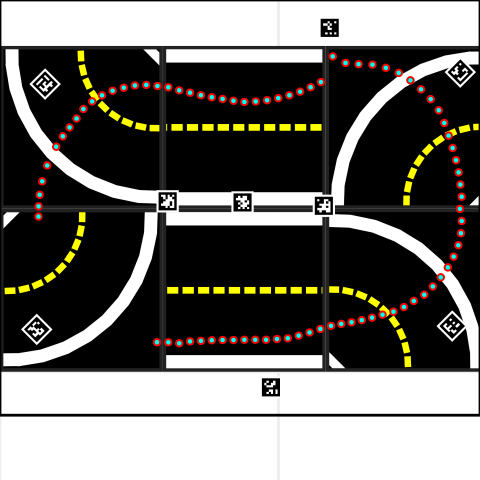

INFO:dt-world:area: RectangularArea(pmin=[ 0.    -0.156],pmax=[1.72371067 1.33500001])
INFO:dt-world:Written SVG to out/ipython_draw_svg/140405488886616/drawing.svg
INFO:dt-world:Written HTML to out/ipython_draw_svg/140405488886616/drawing.html


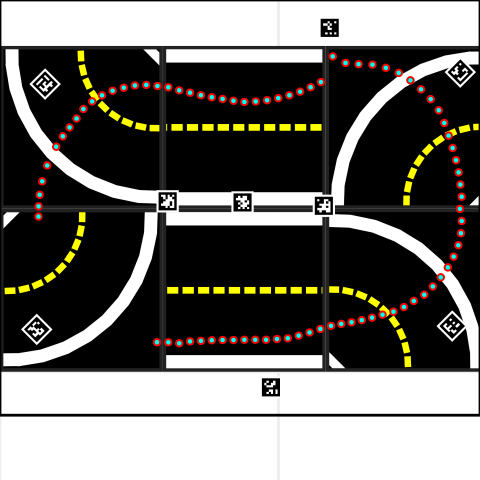

INFO:dt-world:area: RectangularArea(pmin=[ 0.    -0.156],pmax=[1.72371067 1.33500001])
INFO:dt-world:Written SVG to out/ipython_draw_svg/140405488886616/drawing.svg
INFO:dt-world:Written HTML to out/ipython_draw_svg/140405488886616/drawing.html


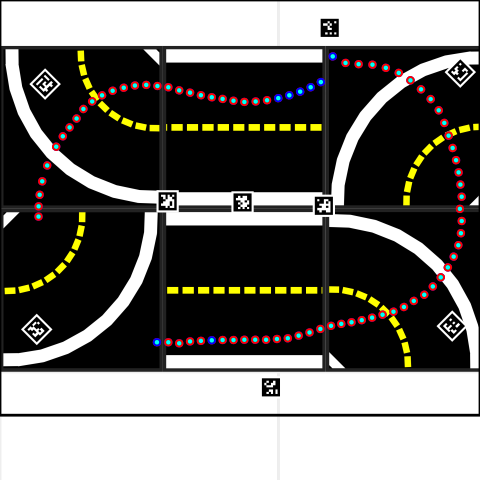

In [114]:
del m
m = dw.load_map('linus_loop')

colors = ['green','cyan','blue','yellow','magenta']
for k in range(0, compare_a[0]['Number of tests ran']):
    
    current_traj_tfs = all_int_traj_test_a[k]
    for i, meant_tf in enumerate(current_traj_tfs):
        if not(i%2):
            if current_traj_tfs[i] != None:
                m.set_object('Data-%s'% k+str(i + 10000), Circle(0.008, color=colors[k]), ground_truth=meant_tf)

for i, meant_tf in enumerate(mean_tfs_a):
    if not(i%2):
        m.set_object(str(i), Circle(0.015, color='red'), ground_truth=meant_tf)

ipython_draw_svg(m);

for k in range(0, compare_b[0]['Number of tests ran']):
    
    current_traj_tfs = all_int_traj_test_b[k]
    for i, meant_tf in enumerate(current_traj_tfs):
        if not(i%2):
            if current_traj_tfs[i] != None:
                m.set_object('Data-%s'% k+str(i + 10000), Circle(0.008, color=colors[k]), ground_truth=meant_tf)

for i, meant_tf in enumerate(mean_tfs_b):
    if not(i%2):
        m.set_object(str(i), Circle(0.015, color='red'), ground_truth=meant_tf)

ipython_draw_svg(m);

for i, meant_tf in enumerate(mean_tfs_a):
    if not(i%2):
        m.set_object(str(i+1000), Circle(0.015, color='blue'), ground_truth=meant_tf)

for i, meant_tf in enumerate(mean_tfs_b):
    if not(i%2):
        m.set_object(str(i), Circle(0.015, color='red'), ground_truth=meant_tf)

ipython_draw_svg(m);

In [115]:
no_meaningful_comp = ['Tolerance_out_of_sight', 'Tolerance_too_slow_sec', 'Theoretical_length_of_benchmark']
no_meaningful_rel_comp = ['Out_of_sight', 'Too_slow']
boolean_comp = ['Out_of_sight', 'Too_slow']
tolerances = ['Tolerance_out_of_sight [seconds]', 'Tolerance_too_slow_sec [seconds]', 'Theoretical_length_of_benchmark [seconds]']
time_comp = ['Time_out_of_sight', 'Time_too_slow','Actual_length_of_benchmark']
list_of_comp_todo = ['Position_too_slow', 'Time_needed_per_straight_tile_sec', 'Time_needed_per_curved_tile']
meaningful_comp_results = ['Number_of_tiles_covered','Avg_time_needed_per_tile','mean_diff_btw_estimation_and_ground_truth_offset',\
                          'mean_diff_btw_estimation_and_ground_truth_angle', 'Abs_Measurements_db_mean_offset',\
                          'Abs_Measurements_db_mean_angle','Abs_Ground_truth_wt_mean_offset_interp',\
                          'Abs_Ground_truth_wt_mean_angle_interp','Abs_Ground_truth_wt_mean_offset_non_interp',\
                          'Abs_Ground_truth_wt_mean_angle_non_interp','Time_out_of_sight', 'Time_too_slow',\
                           'Actual_length_of_benchmark']
high_better = ['Number_of_tiles_covered','Time_out_of_sight','Time_too_slow','Actual_length_of_benchmark']
low_better = ['Avg_time_needed_per_tile','mean_diff_btw_estimation_and_ground_truth_offset',\
              'mean_diff_btw_estimation_and_ground_truth_angle', 'Abs_Measurements_db_mean_offset',\
              'Abs_Measurements_db_mean_angle','Abs_Ground_truth_wt_mean_offset_interp',\
              'Abs_Ground_truth_wt_mean_angle_interp','Abs_Ground_truth_wt_mean_offset_non_interp',\
              'Abs_Ground_truth_wt_mean_angle_non_interp']

In [116]:
if do_comparison:
    for item in meaningful_comp_results:
        mean_a = compare_a[0]['Results'][item]['Mean']
        mean_b = compare_b[0]['Results'][item]['Mean']
        median_a = compare_a[0]['Results'][item]['Median']
        median_b = compare_b[0]['Results'][item]['Median']
        std_a = compare_a[0]['Results'][item]['Std']
        std_b = compare_b[0]['Results'][item]['Std']
        cv_a = compare_a[0]['Results'][item]['coefficient of variation calculation']
        cv_b = compare_b[0]['Results'][item]['coefficient of variation calculation']
        min_a = compare_a[0]['Results'][item]['Min']
        max_a = compare_a[0]['Results'][item]['Max']
        min_b = compare_b[0]['Results'][item]['Min']
        max_b = compare_b[0]['Results'][item]['Max']
        unit = compare_b[0]['Results'][item]['Unit']
        if len(item) > 20:
            splitat = 28
            h, l = item[:splitat], item[splitat:]
            if item =='Number_of_tiles_covered':
                print(h+'\t\tBenchmark A\tBenchmark B\tdifference\tB rel. to A\t\tWinner')
                print(l+' ['+unit+']')
            else:
                print(h+'\tBenchmark A\tBenchmark B\tdifference\tB rel. to A\t\tWinner')
                print(l+' ['+unit+']')
        else:
            if item =='Time_out_of_sight':
                print(item+'\t\tBenchmark A\tBenchmark B\tdifference\tB rel. to A\t\tWinner')
                print(' ['+unit+']')
            elif item =='Time_too_slow':
                print(item+'\t\t\tBenchmark A\tBenchmark B\tdifference\tB rel. to A\t\tWinner')
                print(' ['+unit+']')
            else:
                print(item+'\tBenchmark A\tBenchmark B\tdifference\tB relative to A\t\tWinner')
                print(' ['+unit+']')
        print('--------------------------------------------------------------------------------------------------------------')
        if item in low_better:
            win,brela,diff,sign = comp_low_bet(mean_a,mean_b)
        elif item in high_better:
            win,brela,diff,sign = comp_high_bet(mean_a,mean_b)
        advantages.update({item: win})
        print('Mean' + ':\t\t\t\t', float(np.round(mean_a,2)), '\t\t', float(np.round(mean_b,2)), '\t\t',float(np.round(diff,2)), '\t\t',float(np.round(brela,2)),'\t\t\t',win)
        if item in low_better:
            win,brela,diff,sign = comp_low_bet(std_a,std_b)
        elif item in high_better:
            win,brela,diff,sign = comp_high_bet(std_a,std_b)
        print('Std' + ':\t\t\t\t', float(np.round(std_a,1)), '\t\t', float(np.round(std_b,1)), '\t\t',float(np.round(diff,2)), '\t\t',float(np.round(brela,2)),'\t\t\t',win)
        if item in low_better:
            win,brela,diff,sign = comp_low_bet(min_a,min_b)
        elif item in high_better:
            win,brela,diff,sign = comp_high_bet(min_a,min_b)
        print('Min' + ':\t\t\t\t', float(np.round(min_a,2)), '\t\t', float(np.round(min_b,2)), '\t\t',float(np.round(diff,2)), '\t\t',float(np.round(brela,2)),'\t\t\t',win)
        if item in low_better:
            win,brela,diff,sign = comp_low_bet(max_a,max_b)
        elif item in high_better:
            win,brela,diff,sign = comp_high_bet(max_a,max_b)
        print('Max' + ':\t\t\t\t', float(np.round(max_a,2)), '\t\t', float(np.round(max_b,2)), '\t\t',float(np.round(diff,2)), '\t\t',float(np.round(brela,2)),'\t\t\t',win)

        print('\n')
        
else:
    for item in meaningful_comp_results:
        mean_a = compare_a[0]['Results'][item]['Mean']
        median_a = compare_a[0]['Results'][item]['Median']
        std_a = compare_a[0]['Results'][item]['Std']
        cv_a = compare_a[0]['Results'][item]['coefficient of variation calculation']
        min_a = compare_a[0]['Results'][item]['Min']
        max_a = compare_a[0]['Results'][item]['Max']
        unit = compare_b[0]['Results'][item]['Unit']
        if len(item) > 20:
            splitat = 28
            h, l = item[:splitat], item[splitat:]
            if item =='Number_of_tiles_covered':
                print(h+'\t\tBenchmark A')
                print(l+' ['+unit+']')
            else:
                print(h+'\tBenchmark A')
                print(l+' ['+unit+']')
        else:
            if item =='Time_out_of_sight':
                print(item+'\t\tBenchmark A')
                print(' ['+unit+']')
            elif item =='Time_too_slow':
                print(item+'\t\t\tBenchmark A')
                print(' ['+unit+']')
            else:
                print(item+'\tBenchmark A')
                print(' ['+unit+']')
        print('--------------------------------------------------------------------------------------------------------------')
     
        print('Mean' + ':\t\t\t\t', float(np.round(mean_a,2)))
        print('Std' + ':\t\t\t\t', float(np.round(std_a,1)))
        print('Min' + ':\t\t\t\t', float(np.round(min_a,2)))
        print('Max' + ':\t\t\t\t', float(np.round(max_a,2)))

        print('\n')

Number_of_tiles_covered		Benchmark A	Benchmark B	difference	B rel. to A		Winner
 [tiles]
--------------------------------------------------------------------------------------------------------------
Mean:				 6.0 		 6.0 		 0.0 		 100.0 			 equal
Std:				 0.0 		 0.0 		 0.0 		 100.0 			 equal
Min:				 6.0 		 6.0 		 0.0 		 100.0 			 equal
Max:				 6.0 		 6.0 		 0.0 		 100.0 			 equal


Avg_time_needed_per_tile	Benchmark A	Benchmark B	difference	B rel. to A		Winner
 [seconds per tile]
--------------------------------------------------------------------------------------------------------------
Mean:				 3.0 		 3.0 		 0.0 		 100.0 			 equal
Std:				 0.0 		 0.0 		 0.0 		 100.0 			 equal
Min:				 3.0 		 3.0 		 0.0 		 100.0 			 equal
Max:				 3.0 		 3.0 		 0.0 		 100.0 			 equal


mean_diff_btw_estimation_and	Benchmark A	Benchmark B	difference	B rel. to A		Winner
_ground_truth_offset [meters]
-----------------------------------------------------------------------------------------------------

In [117]:
if do_comparison:
    for item in tolerances:
        tol_a = compare_a[0]['Results'][item]
        tol_b = compare_a[0]['Results'][item]
        print("In the Benchmark A the constant " +item+ " was set to {0} and in the Benchmark B it was set to {1}".format(tol_a,tol_b))
else:  
    for item in tolerances:
        tol_a = compare_a[0]['Results'][item]
        print("In the your Benchmark the constant " +item+ " was set to {0}.".format(tol_a,tol_b))


In the Benchmark A the constant Tolerance_out_of_sight [seconds] was set to 3.0 and in the Benchmark B it was set to 3.0
In the Benchmark A the constant Tolerance_too_slow_sec [seconds] was set to 15.0 and in the Benchmark B it was set to 15.0
In the Benchmark A the constant Theoretical_length_of_benchmark [seconds] was set to 50.0 and in the Benchmark B it was set to 50.0


In [118]:
if do_comparison:
    for item in boolean_comp:
        nb_fail_a = compare_a[0]['Results'][item]['Mean']
        nb_fail_b = compare_b[0]['Results'][item]['Mean']
        am_of_fail_a = nb_fail_a.replace(' failures','')
        am_of_fail_b = nb_fail_b.replace(' failures','')
        win,brela,diff,sign = comp_low_bet(float(am_of_fail_a),float(am_of_fail_b))
        advantages.update({item: win})
        print("Benchmark A had {0} and Benchmark B had {1} due to ".format(nb_fail_a,nb_fail_b)+item)

Benchmark A had 2 failures and Benchmark B had 2 failures due to Out_of_sight
Benchmark A had 0 failures and Benchmark B had 0 failures due to Too_slow


In [119]:
amount_of_adv_a = 0
amount_of_adv_b = 0
amount_of_eq_prop = 0
adv_of_a = []
adv_of_b = []
equal_prop = []
for i, prop in enumerate(advantages):
    if advantages[prop] == 'A':
        amount_of_adv_a += 1
        adv_of_a.append(prop)
    elif advantages[prop] == 'B':
        amount_of_adv_b += 1
        adv_of_b.append(prop)
    elif advantages[prop] == 'equal':
        amount_of_eq_prop += 1
        equal_prop.append(prop)
    else:
        print("Something went wrong with the property: "+prop)

pprint.pprint(advantages)
print(amount_of_adv_a)
print(adv_of_a)
print(amount_of_adv_b)
print(adv_of_b)
print(amount_of_eq_prop)
print(equal_prop)

{'/autobot01/lane_filter_node/lane_pose': 'equal',
 '/autobot01/line_detector_node/segment_list': 'equal',
 '/rosout': 'equal',
 'Abs_Ground_truth_wt_mean_angle_interp': 'equal',
 'Abs_Ground_truth_wt_mean_angle_non_interp': 'equal',
 'Abs_Ground_truth_wt_mean_offset_interp': 'equal',
 'Abs_Ground_truth_wt_mean_offset_non_interp': 'equal',
 'Abs_Measurements_db_mean_angle': 'equal',
 'Abs_Measurements_db_mean_offset': 'equal',
 'Actual_length_of_benchmark': 'equal',
 'Avg_time_needed_per_tile': 'equal',
 'Latency': 'equal',
 'Number_of_tiles_covered': 'equal',
 'Out_of_sight': 'equal',
 'Overall CPU (CPU used in %)': 'equal',
 'Overall Mem (memory used in %)': 'equal',
 'Overall Swaps (Swaps used in %)': 'equal',
 'Segment Count': 'equal',
 'Time_out_of_sight': 'equal',
 'Time_too_slow': 'equal',
 'Too_slow': 'equal',
 'autobot01-duckiebot_visualizer-5.log': 'equal',
 'autobot01-fsm_node-1.log': 'equal',
 'autobot01-ground_projection-4.log': 'equal',
 'autobot01-lane_controller_node-8.

In [ ]:
benchmark_result_comparison_graph = path.join(experiment_dir, 'out/benchmark_result_comparison_graph.jpg')

fig, axes = plt.subplots(nrows=ceil((len(results)-len(no_meaningful_comp)-len(list_of_comp_todo))/2), ncols=2)
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Different performances', y=.895)

objects = (name_a, name_b)
x_pos = np.arange(len(objects))
count = 0

for i in (range(0, len(results))):
        if (results[i] not in no_meaningful_comp) and (results[i] not in list_of_comp_todo):
            performance = [(compare_a[0]['Results'][results[i]]),([compare_b[0]['Results'][results[i]]])]
            if results[i] in adv_of_a:
                winner_color = ['green', 'red']
            elif results[i] in adv_of_b:
                winner_color = ['red', 'green']
            elif results[i] in equality:
                winner_color = ['blue', 'blue']   
            else:
                winner_color = ['black', 'black']
                
            ax = axes.flatten()[count]
            ax.bar(x_pos, performance, align='center', alpha=0.5, color=winner_color)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(objects)
            ax.set_ylabel(unit_list[i])
            ax.set_title(results[i])

            count+=1
                

fig.set_figheight(40)
fig.set_figwidth(15)

plt.savefig(benchmark_result_comparison_graph, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

    


In [ ]:
benchmark_result_comparison = path.join(experiment_dir, 'out/benchmark_result_comparison.yaml')

with open(benchmark_result_comparison, 'w') as yaml_file:
    yaml.dump(comparison, yaml_file, default_flow_style=False)

In [ ]:
benchmark_result_comparison_2 = path.join(experiment_dir, 'out/benchmark_result_comparison_2.yaml')
unit_list = []
with open(benchmark_result_comparison_2, 'w') as yaml_file:
    header = ["score_a", "score_b", "difference_abs(a)_minus_abs(b)", "unit", "b_relative_to_a", \
              "dec/incr_in_percentage", "b_compared_to_a"]
    data = {"data_header": {"Compared_benchmarks":  name_a+' (= a) vs '+name_b + ' (= b)',"property": header}}
    data["results"] = {}
    
    for i in range(0, len(results)):
        if results[i] not in no_meaningful_comp:
            info, unit_current = get_comparison_2(results[i], compare_a[0]['Results'][results[i]], compare_b[0]['Results'][results[i]])
            data["results"][results[i]] = info
            unit_list.append(unit_current)
        else:
            unit_list.append('not defined')
    yaml.dump(data, yaml_file, default_flow_style=False)

## Some utilities that we are going to use later

TypeError: unsupported operand type(s) for +: 'int' and 'dict'

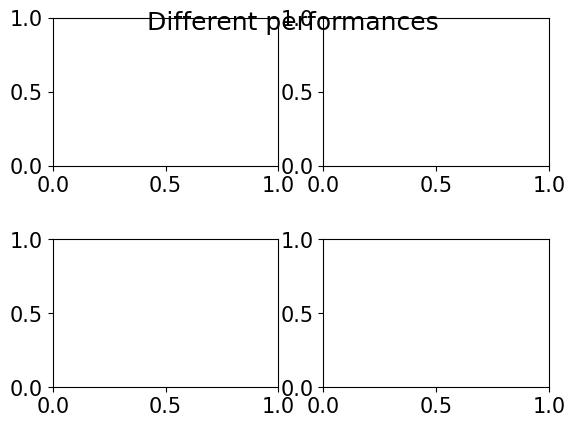

In [ ]:
from reportlab.pdfgen import canvas

In [ ]:
adv_of_a = []
adv_of_b = []
equality = []

def low_better(result_a, result_b, diff_btw_results, unit, info):
    
    if np.sign(diff_btw_results) == 1:
        adv_of_b.append(info)
        rel_comp = repr(abs(diff_btw_results)) + ' ' + unit + ' more (worse) than '
    elif np.sign(diff_btw_results) == -1:
        adv_of_a.append(info)
        rel_comp = repr(abs(diff_btw_results)) + ' ' + unit + ' less (better) than '
    elif np.sign(diff_btw_results) == 0:
        equality.append(info)
        rel_comp = 'exactly the same'
    else:
        rel_comp = 'What the fuck'

    comp_text = 'In this field of ' + name_a + ' achieved ' + repr(result_a) + \
                    ' this is '+ rel_comp + name_b + ' which achieved ' + repr(result_b) + '.'
    
    return comp_text

def high_better(result_a, result_b, diff_btw_results, unit, info):
    
    if np.sign(diff_btw_results) == 1:
        adv_of_a.append(info)
        rel_comp = repr(abs(diff_btw_results)) + ' ' + unit + ' more (better) than '
    elif np.sign(diff_btw_results) == -1:
        adv_of_b.append(info)
        rel_comp = repr(abs(diff_btw_results)) + ' ' + unit + ' less (worse) than '
    elif np.sign(diff_btw_results) == 0:
        equality.append(info)
        rel_comp = 'exactly the same'
    else:
        rel_comp = 'What the fuck'

    comp_text = 'In this field of ' + name_a + ' achieved ' + repr(result_a) + \
                        ' this is '+ rel_comp + name_b + ' which achieved ' + repr(result_b) + '.'
    
    return comp_text

def low_better_rel(diff_btw_results):
    
    if np.sign(diff_btw_results) == 1:
        rel_comp = 'better'
    elif np.sign(diff_btw_results) == -1:
        rel_comp = 'worse'
    elif np.sign(diff_btw_results) == 0:
        rel_comp = 'equal'
    else:
        rel_comp = 'What the fuck'

    return rel_comp

def high_better_rel(diff_btw_results):
    
    if np.sign(diff_btw_results) == 1:
        rel_comp = 'worse'
    elif np.sign(diff_btw_results) == -1:
        rel_comp = 'better'
    elif np.sign(diff_btw_results) == 0:
        rel_comp = 'equal'
    else:
        rel_comp = 'What the fuck'

    return rel_comp

def compare_true_false(result_a, result_b, info):
    
    if result_a == True:
        if result_b == True:
            rel_comp = 'They were both ' + info + ' before the benchmark was finished'
            equality.append(info)
        elif result_b == False:
            rel_comp = 'Only a was ' + info + ' before the benchmark was finished. B finished normaly'  
            adv_of_b.append(info)
    elif result_a == False:
        if result_b == True:
            rel_comp = 'Only b was ' + info + ' before the benchmark was finished. A finished normaly'
            adv_of_a.append(info)
        elif result_b == False:
            rel_comp = 'They were both never ' + info + ' and the Benchmark was in both cases successfully completed'  
            equality.append(info)
    else:
        rel_comp = 'What the fuck'

    return rel_comp

def get_sign(number):
    if np.sign(number) == 1:
        sign = '+'
    elif np.sign(number) == -1:
        sign = '-'
    elif np.sign(number) == 0:
        sign = ' '
    else:
        sign = 'sth weird happend'
        
    return sign
def get_comparison(info, result_a, result_b):
    
    
    if result_a['Mean'] != 'ToDo':
        diff_btw_results = abs(float(result_a['Mean'])) - abs(float(result_b['Mean']))
        if info == 'Number_of_completed_laps':
            unit = 'laps'
            comp_text = high_better(result_a, result_b, diff_btw_results, unit, info)
        elif info == 'Number_of_tiles_covered':
            unit = 'tiles'
            comp_text = high_better(result_a, result_b, diff_btw_results, unit, info)
        elif info == 'Avg_time_needed_per_tile':
            unit = 'seconds per tile'
            comp_text = low_better(result_a, result_b, diff_btw_results, unit, info)
        elif info == 'Time_needed_per_straight_tile_sec':
            unit = 'seconds per tile'
            comp_text = low_better(result_a, result_b, diff_btw_results, unit, info)
        elif info == 'Time_needed_per_curved_tile':
            unit = 'seconds per tile'
            comp_text = low_better(result_a, result_b, diff_btw_results, unit, info)
#         elif info == 'Theoretical_length_of_benchmark':
#             unit = 'seconds'
        elif info == 'Length_of_recorded_bag':
            unit = 'seconds' 
            comp_text = high_better(result_a, result_b, diff_btw_results, unit, info)
        elif info == 'Actual_length_of_benchmark':
            unit = 'seconds'    
            comp_text = high_better(result_a, result_b, diff_btw_results, unit, info)
        elif info == 'Out_of_sight':
            unit = ' '  
            comp_text = compare_true_false(result_a, result_b, info)
        elif info == 'Time_out_of_sight':
            unit = 'seconds' 
            comp_text = high_better(result_a, result_b, diff_btw_results, unit, info)
        elif info == 'Too_slow':
            unit = ' '
            comp_text = compare_true_false(result_a, result_b, info)
        elif info == 'Time_too_slow':
            unit = 'seconds' 
            comp_text = high_better(result_a, result_b, diff_btw_results, unit, info)
        elif info == 'Position_too_slow':
            unit = ' '   
            comp_text = 'ToDo'
        elif info == 'Ground_truth_wt_std_offset':
            unit = 'meters' 
            comp_text = low_better(result_a, result_b, diff_btw_results, unit, info)
        elif info == 'Ground_truth_wt_std_angle':
            unit = 'radians' 
            comp_text = low_better(result_a, result_b, diff_btw_results, unit, info)
        elif info == 'Ground_truth_wt_mean_offset':
            unit = 'meters' 
            comp_text = low_better(result_a, result_b, diff_btw_results, unit, info)
        elif info == 'Ground_truth_wt_mean_angle':
            unit = 'radians' 
            comp_text = low_better(result_a, result_b, diff_btw_results, unit, info)
        elif info == 'Measurements_db_std_offset':
            unit = 'meters'
            comp_text = low_better(result_a, result_b, diff_btw_results, unit, info)
        elif info == 'Measurements_db_std_angle':
            unit = 'radians' 
            comp_text = low_better(result_a, result_b, diff_btw_results, unit, info)
        elif info == 'Measurements_db_mean_offset':
            unit = 'meters' 
            comp_text = low_better(result_a, result_b, diff_btw_results, unit, info)
        elif info == 'Measurements_db_mean_angle':
            unit = 'radians' 
            comp_text = low_better(result_a, result_b, diff_btw_results, unit, info)
        elif info == 'std_diff_btw_estimation_and_ground_truth_offset':
            unit = 'meters' 
            comp_text = low_better(result_a, result_b, diff_btw_results, unit, info)
        elif info == 'std_diff_btw_estimation_and_ground_truth_angle':
            unit = 'radians'
            comp_text = low_better(result_a, result_b, diff_btw_results, unit, info)
        elif info == 'mean_diff_btw_estimation_and_ground_truth_offset':
            unit = 'meters' 
            comp_text = low_better(result_a, result_b, diff_btw_results, unit, info)
        elif info == 'mean_diff_btw_estimation_and_ground_truth_angle':
            unit = 'radians'
            comp_text = low_better(result_a, result_b, diff_btw_results, unit, info)
        else:
            unit = 'Uuuups' 
            comp_text = result_a
        
    else:
        comp_text = 'No comparison applicable'
    
    return comp_text

def get_comparison_2(info, result_a, result_b):
    
    row = []
    
    if result_a['Mean'] != 'ToDo':
        
        diff_btw_results = abs(float(result_a['Mean'])) - abs(float(result_b['Mean']))
        if result_a != 0:
            relativ = 100.0/abs(float(result_a['Mean'])) * abs(float(result_b['Mean']))
        else:
            relativ = 100.0
        
        rel_change = relativ - 100.0
        if info not in no_meaningful_rel_comp:
            row.append(str("%.4f" % result_a['Mean']))
            row.append(str("%.4f" % result_b['Mean']))
            row.append(str(get_sign(-diff_btw_results) + " %.8f" % abs(diff_btw_results)))
        else:
            row.append(str(result_a['Mean']))
            row.append(str(result_b['Mean']))
            row.append(str(""))
        
        if info == 'Number_of_completed_laps':
            unit = 'laps'
            comp_text = high_better_rel(diff_btw_results)
        elif info == 'Number_of_tiles_covered':
            unit = 'tiles'
            comp_text = high_better_rel(diff_btw_results)
        elif info == 'Avg_time_needed_per_tile':
            unit = 'seconds per tile'
            comp_text = low_better_rel(diff_btw_results)
        elif info == 'Time_needed_per_straight_tile_sec':
            unit = 'seconds per tile'
            comp_text = low_better_rel(diff_btw_results)
        elif info == 'Time_needed_per_curved_tile':
            unit = 'seconds per tile'
            comp_text = low_better_rel(diff_btw_results)
#         elif info == 'Theoretical_length_of_benchmark':
#             unit = 'seconds'
        elif info == 'Length_of_recorded_bag':
            unit = 'seconds' 
            comp_text = high_better_rel(diff_btw_results)
        elif info == 'Actual_length_of_benchmark':
            unit = 'seconds'   
            comp_text = high_better_rel(diff_btw_results)
        elif info == 'Out_of_sight':
            unit = ' '  
            comp_text = compare_true_false(result_a, result_b, info) 
        elif info == 'Time_out_of_sight':
            unit = 'seconds' 
            comp_text = high_better_rel(diff_btw_results)
        elif info == 'Too_slow':
            unit = ' '  
            comp_text = compare_true_false(result_a, result_b, info)
        elif info == 'Time_too_slow':
            unit = 'seconds' 
            comp_text = high_better_rel(diff_btw_results)
        elif info == 'Position_too_slow':
            unit = ' '
            comp_text = ' ToDo '
        elif info == 'Ground_truth_wt_std_offset':
            unit = 'meters' 
            comp_text = low_better_rel(diff_btw_results)
        elif info == 'Ground_truth_wt_std_angle':
            unit = 'radians' 
            comp_text = low_better_rel(diff_btw_results)
        elif info == 'Ground_truth_wt_mean_offset':
            unit = 'meters' 
            comp_text = low_better_rel(diff_btw_results)
        elif info == 'Ground_truth_wt_mean_angle':
            unit = 'radians' 
            comp_text = low_better_rel(diff_btw_results)
        elif info == 'Measurements_db_std_offset':
            unit = 'meters'
            comp_text = low_better_rel(diff_btw_results)
        elif info == 'Measurements_db_std_angle':
            unit = 'radians' 
            comp_text = low_better_rel(diff_btw_results)
        elif info == 'Measurements_db_mean_offset':
            unit = 'meters' 
            comp_text = low_better_rel(diff_btw_results)
        elif info == 'Measurements_db_mean_angle':
            unit = 'radians' 
            comp_text = low_better_rel(diff_btw_results)
        elif info == 'std_diff_btw_estimation_and_ground_truth_offset':
            unit = 'meters' 
            comp_text = low_better_rel(diff_btw_results)
        elif info == 'std_diff_btw_estimation_and_ground_truth_angle':
            unit = 'radians'
            comp_text = low_better_rel(diff_btw_results)
        elif info == 'mean_diff_btw_estimation_and_ground_truth_offset':
            unit = 'meters' 
            comp_text = low_better_rel(diff_btw_results)
        elif info == 'mean_diff_btw_estimation_and_ground_truth_angle':
            unit = 'radians'
            comp_text = low_better_rel(diff_btw_results)
        else:
            unit = 'Uuuups' 
            comp_text = 'upsidupsi'
        
        if info not in no_meaningful_rel_comp:
            row.append(str(unit))
            row.append(str(" %.2f" % abs(relativ) + " %"))
            row.append(str(get_sign(-diff_btw_results) + " %.2f" % abs(rel_change) + " %"))
            row.append(str(comp_text))
        else:
            row.append('')
            row.append(str(""))
            row.append(str(""))
            row.append(str(comp_text))
    
    else:
        unit = 'Not defined'
        row.append(str("Not defined yet"))
    
    return row, unit